In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats

import src.data
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.visualization
import sak.visualization.plot
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.train
import sak.torch.data
import sak.data.preprocessing
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

In [7]:
np.linspace(0.5,0,51)[24]

0.26

# Training the network

In [9]:
with open('./configurations/UNet5Levels.json', 'r') as f:
    execution = json.load(f)

In [10]:
# P = sak.pickleload(os.path.join('.','pickle','Psignal_new.pkl'))
# PQ = sak.pickleload(os.path.join('.','pickle','PQsignal_new.pkl'))
# QRS = sak.pickleload(os.path.join('.','pickle','QRSsignal_new.pkl'))
# ST = sak.pickleload(os.path.join('.','pickle','STsignal_new.pkl'))
# T = sak.pickleload(os.path.join('.','pickle','Tsignal_new.pkl'))
# TP = sak.pickleload(os.path.join('.','pickle','TPsignal_new.pkl'))

# Pamplitudes = sak.pickleload(os.path.join('.','pickle','Pamplitudes_new.pkl'))
# PQamplitudes = sak.pickleload(os.path.join('.','pickle','PQamplitudes_new.pkl'))
# QRSamplitudes = sak.pickleload(os.path.join('.','pickle','QRSamplitudes_new.pkl'))
# STamplitudes = sak.pickleload(os.path.join('.','pickle','STamplitudes_new.pkl'))
# Tamplitudes = sak.pickleload(os.path.join('.','pickle','Tamplitudes_new.pkl'))
# TPamplitudes = sak.pickleload(os.path.join('.','pickle','TPamplitudes_new.pkl'))

# Pdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Pamplitudes.values()))))
# PQdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(PQamplitudes.values()))))
# QRSdistribution = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.hstack((np.array(list(QRSamplitudes.values())), 2-np.array(list(QRSamplitudes.values()))))))
# # QRSdistribution = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(QRSamplitudes.values()))))
# STdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(STamplitudes.values()))))
# Tdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Tamplitudes.values()))))
# TPdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(TPamplitudes.values()))))

# # Smooth all
# window = 5
# P   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  P[k],window)),metric=sak.signal.abs_max) for k in   P}
# PQ  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( PQ[k],window)),metric=sak.signal.abs_max) for k in  PQ}
# QRS = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(QRS[k],window)),metric=sak.signal.abs_max) for k in QRS}
# ST  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( ST[k],window)),metric=sak.signal.abs_max) for k in  ST}
# T   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  T[k],window)),metric=sak.signal.abs_max) for k in   T}
# TP  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( TP[k],window)),metric=sak.signal.abs_max) for k in  TP}

# all_keys = {}
# for k in list(P) + list(PQ) + list(QRS) + list(ST) + list(T) + list(TP):
#     uid = k.split('###')[0].split('_')[0].split('-')[0]
#     if uid not in all_keys:
#         all_keys[uid] = [k]
#     else:
#         all_keys[uid].append(k)
        
# # Get database and file
# filenames = []
# database = []
# for k in all_keys:
#     filenames.append(k)
#     if k.startswith('SOO'):
#         database.append(0)
#     elif k.startswith('sel'):
#         database.append(1)
#     else:
#         database.append(2)
# filenames = np.array(filenames)
# database = np.array(database)

# splitter = sklearn.model_selection.StratifiedKFold(5).split(filenames,database)

# original_path = execution['save_directory']
# all_folds_test = {}

# for i,(ix_train,ix_valid) in enumerate(splitter):
#     train_keys, valid_keys = ([],[])
#     for k in np.array(filenames)[ix_train]: train_keys += all_keys[k]
#     for k in np.array(filenames)[ix_valid]: valid_keys += all_keys[k]

#     # Save fold"s validation files for later usage
#     all_folds_test["fold_{}".format(i+1)] = np.array(filenames)[ix_valid]
    
#     # Divide train/valid segments
#     Ptrain   = {k: P[k] for k in P if k in train_keys}
#     PQtrain  = {k: PQ[k] for k in PQ if k in train_keys}
#     QRStrain = {k: QRS[k] for k in QRS if k in train_keys}
#     STtrain  = {k: ST[k] for k in ST if k in train_keys}
#     Ttrain   = {k: T[k] for k in T if k in train_keys}
#     TPtrain  = {k: TP[k] for k in TP if k in train_keys}

#     Pvalid   = {k: P[k] for k in P if k in valid_keys}
#     PQvalid  = {k: PQ[k] for k in PQ if k in valid_keys}
#     QRSvalid = {k: QRS[k] for k in QRS if k in valid_keys}
#     STvalid  = {k: ST[k] for k in ST if k in valid_keys}
#     Tvalid   = {k: T[k] for k in T if k in valid_keys}
#     TPvalid  = {k: TP[k] for k in TP if k in valid_keys}

#     break
    

In [11]:
# dataset_train = src.data.Dataset(Ptrain, QRStrain, Ttrain, PQtrain, STtrain, TPtrain, 
#                                  Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
#                                  STdistribution, TPdistribution, **execution['dataset'])
# dataset_valid = src.data.Dataset(Pvalid, QRSvalid, Tvalid, PQvalid, STvalid, TPvalid, 
#                                  Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
#                                  STdistribution, TPdistribution, **execution['dataset'])

# # Create dataloaders
# loader_train = torch.utils.data.DataLoader(dataset_train,**execution['loader'])
# loader_valid = torch.utils.data.DataLoader(dataset_valid,**execution['loader'])

In [12]:
# for input in loader_train:
#     break

# Load execution configuration

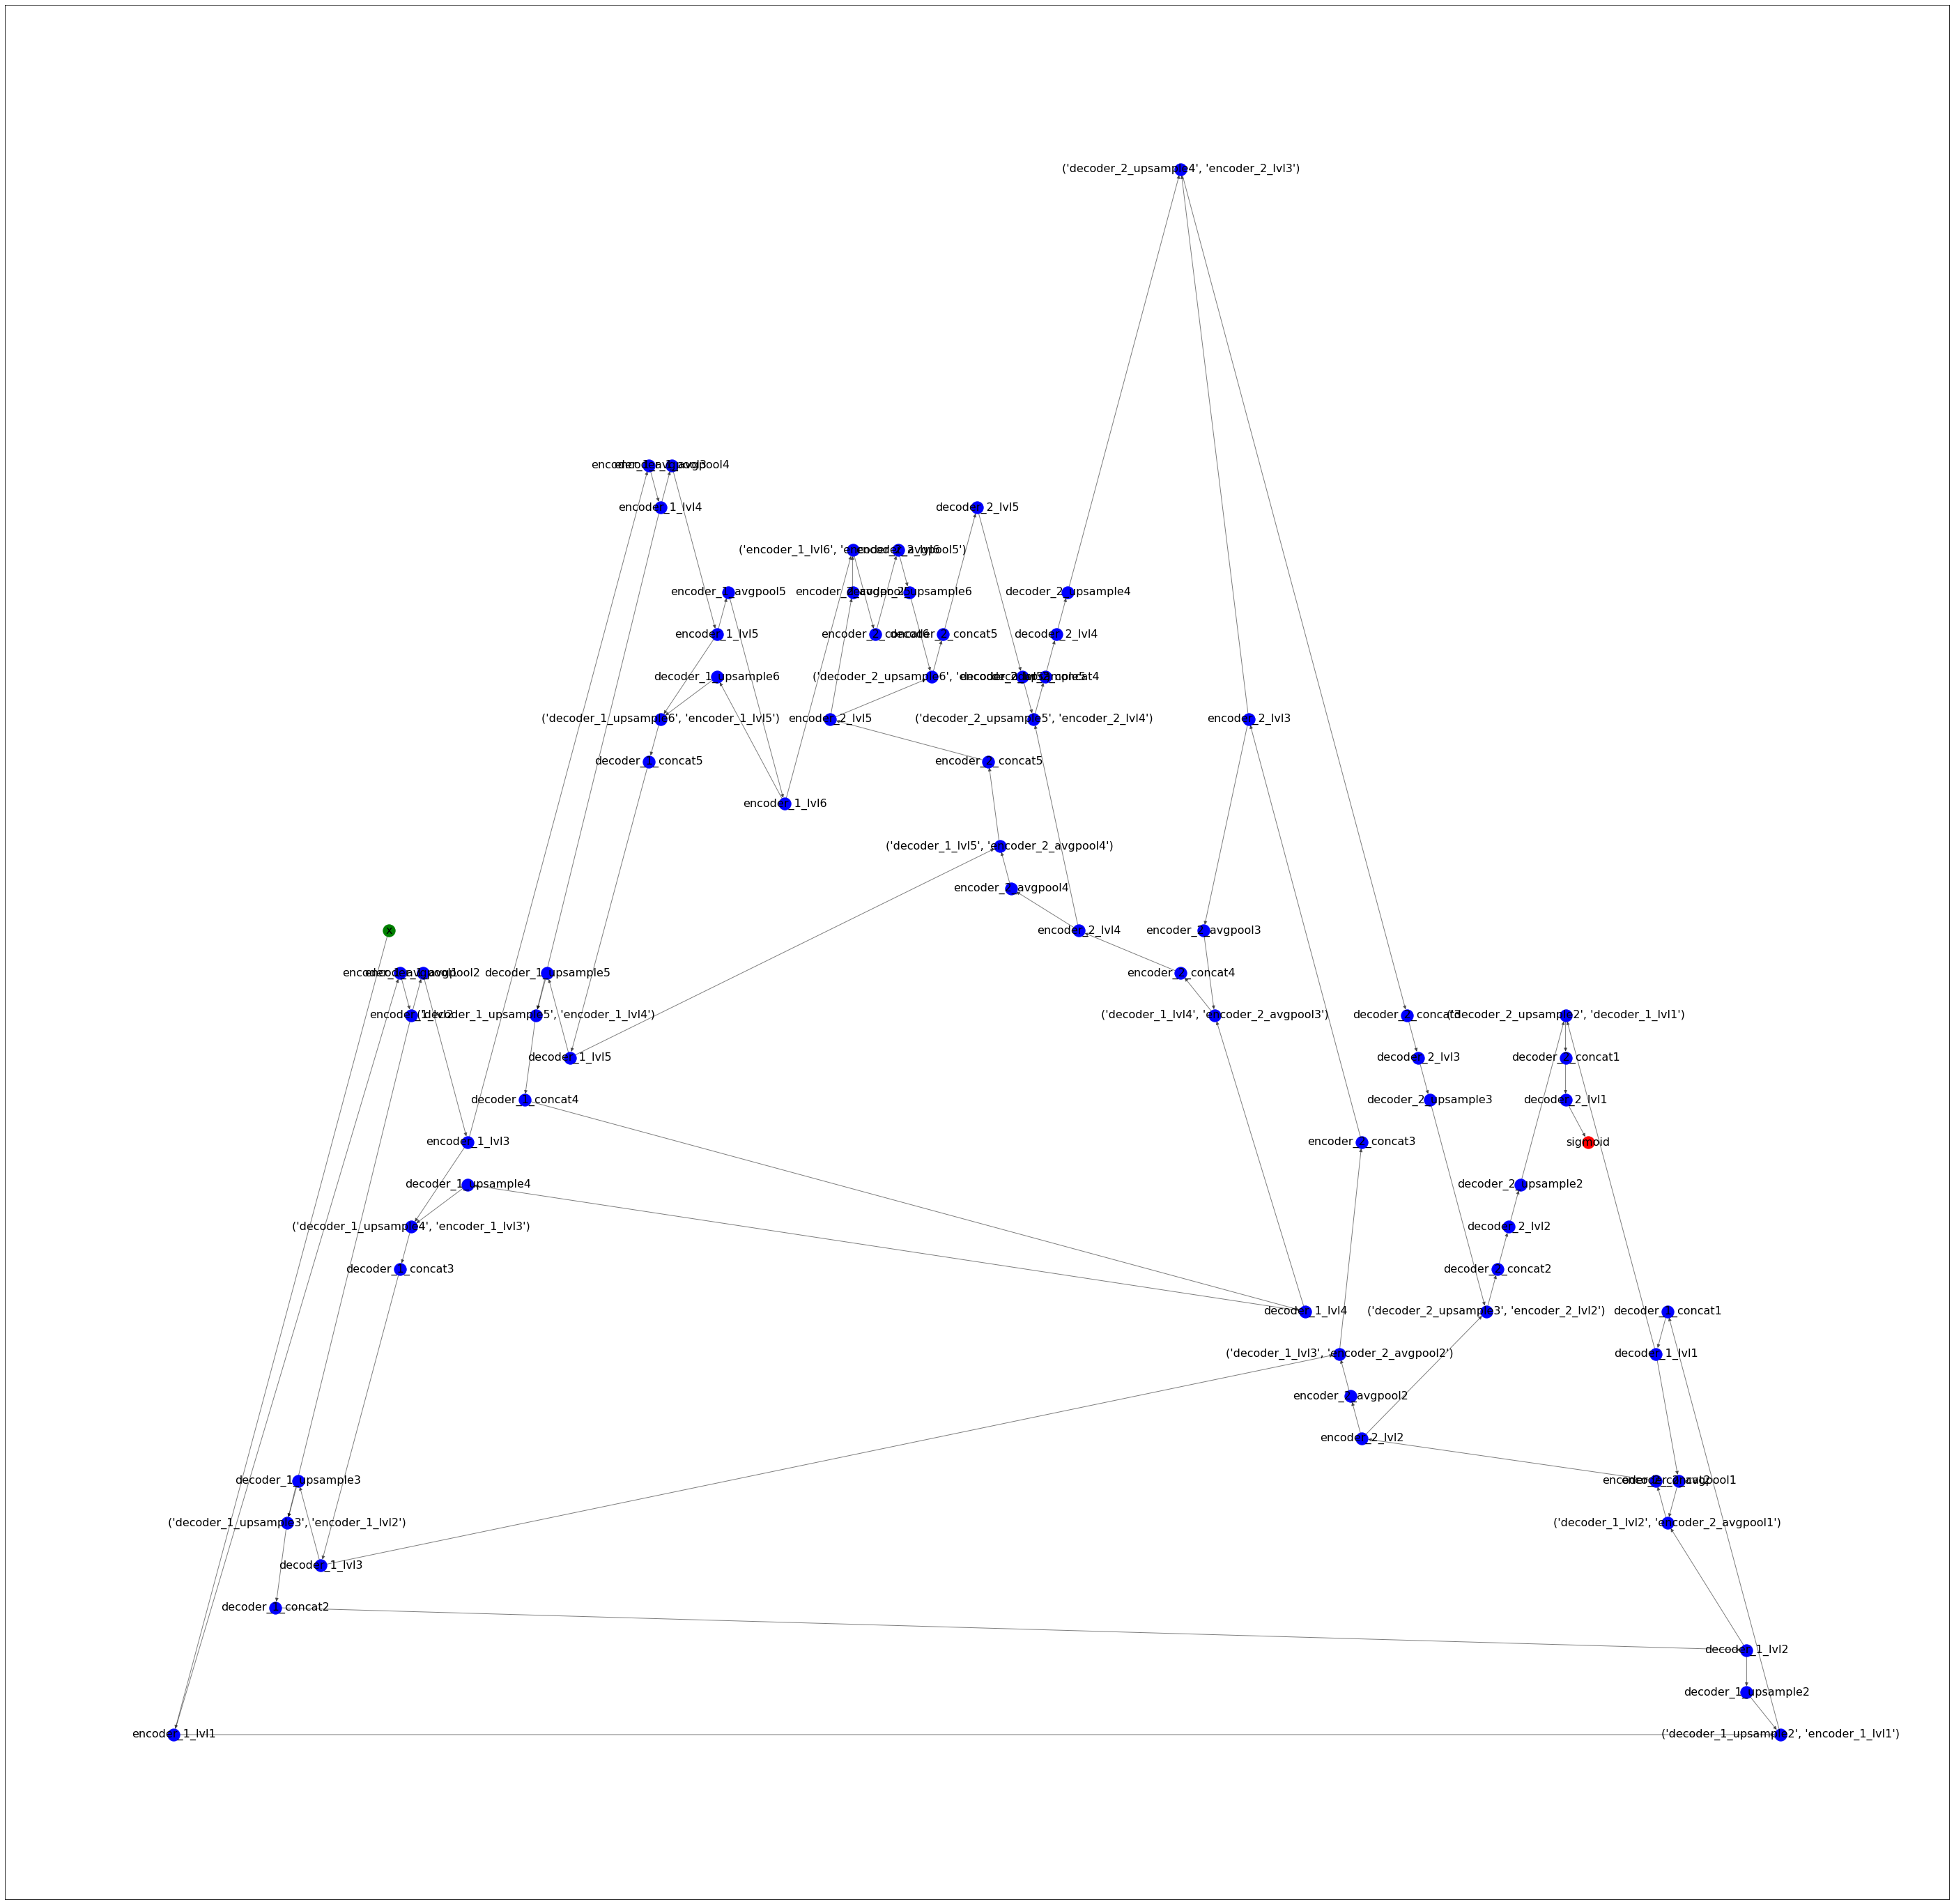

In [9]:
import json
with open('./configurations/WNet6Levels.json', 'r') as f:
    execution = json.load(f)
# Define model
model = sak.from_dict(execution["model"]).float()
plt.figure(figsize=(50,50));model.draw_networkx()

In [14]:
# out = model({"x":torch.rand(16,1,2048)})

In [15]:
input_files = '/media/guille/DADES/DADES/Delineator/'

##### 2. Load QTDB #####
dataset             = pd.read_csv(os.path.join(input_files,'QTDB','Dataset.csv'), index_col=0)
dataset             = dataset.sort_index(axis=1)
labels              = np.asarray(list(dataset)) # In case no data augmentation is applied
description         = dataset.describe()
group               = {k: '_'.join(k.split('_')[:-1]) for k in dataset}
unique_ids          = list(set([k.split('_')[0] for k in dataset]))

# Load validity
validity            = sak.load_data(os.path.join(input_files,'QTDB','validity.csv'))

# Load fiducials
Pon_QTDB            = sak.load_data(os.path.join(input_files,'QTDB','PonNew.csv'))
Poff_QTDB           = sak.load_data(os.path.join(input_files,'QTDB','PoffNew.csv'))
QRSon_QTDB          = sak.load_data(os.path.join(input_files,'QTDB','QRSonNew.csv'))
QRSoff_QTDB         = sak.load_data(os.path.join(input_files,'QTDB','QRSoffNew.csv'))
Ton_QTDB            = sak.load_data(os.path.join(input_files,'QTDB','TonNew.csv'))
Toff_QTDB           = sak.load_data(os.path.join(input_files,'QTDB','ToffNew.csv'))



In [16]:
import src.metrics

In [17]:
counter_P = 0
counter_QRS = 0
counter_T = 0
counter_total = 0
n = 0

for k in validity:
    onsets = validity[k][0::2]
    offsets = validity[k][1::2]
    
    for on,off in zip(onsets,offsets):
        if on > off:
            print(k)
            continue
        if k in Pon_QTDB:
            pon,poff = src.metrics.filter_valid(Pon_QTDB[k],Poff_QTDB[k],on,off)
        else:
            pon,poff = np.array([]),np.array([])
        qrson,qrsoff = src.metrics.filter_valid(QRSon_QTDB[k],QRSoff_QTDB[k],on,off)
        ton,toff     = src.metrics.filter_valid(Ton_QTDB[k],Toff_QTDB[k],on,off)
        
        counter_P += int((poff-pon).sum())
        counter_QRS += int((qrsoff-qrson).sum())
        counter_T += int((toff-ton).sum())
        counter_total += off-on


In [18]:
dice_P = (100*counter_P/counter_total)
dice_QRS = (100*counter_QRS/counter_total)
dice_T = (100*counter_T/counter_total)

In [19]:
# Compute weights
class_weight = np.array([dice_P,dice_QRS,dice_T])
class_weight = np.max(class_weight)/class_weight

In [20]:
class_weight

array([2.19871934, 2.04147921, 1.        ])

In [21]:
total_P   = sum([m.size for m in   Pon_QTDB.values()])
total_QRS = sum([m.size for m in QRSon_QTDB.values()])
total_T   = sum([m.size for m in   Ton_QTDB.values()])

total_QRS/total_P

1.0965058236272878

In [22]:
# Generate masks & signals
signal_QTDB = {}
segmentation_QTDB = {}
for k in tqdm.tqdm(QRSon_QTDB):
    # Check file exists and all that
    if k not in validity:
        print("Issue with file {}, continuing...".format(k))
        continue

    # Store signal
    signal = dataset[k][validity[k][0]:validity[k][1]].values
    signal = sak.signal.on_off_correction(signal)
    amplitude = np.median(sak.signal.moving_lambda(signal,200,sak.signal.abs_max))
    signal = signal/amplitude
    signal_QTDB[k] = signal[None,]

    # Generate boolean mask
    segmentation = np.zeros((3,dataset.shape[0]),dtype=bool)
    if k in Pon_QTDB:
        for on,off in zip(Pon_QTDB[k],Poff_QTDB[k]):
            segmentation[0,on:off] = True
    if k in QRSon_QTDB:
        for on,off in zip(QRSon_QTDB[k],QRSoff_QTDB[k]):
            segmentation[1,on:off] = True
    if k in Ton_QTDB:
        for on,off in zip(Ton_QTDB[k],Toff_QTDB[k]):
            segmentation[2,on:off] = True

    segmentation_QTDB[k] = segmentation[:,validity[k][0]:validity[k][1]]

##### 4. Generate random splits #####
all_keys_real = {}
for k in list(signal_QTDB) + list(segmentation_QTDB):
    uid = k.split("###")[0].split("_")[0].split("-")[0]
    if uid not in all_keys_real:
        all_keys_real[uid] = [k]
    else:
        if k not in all_keys_real[uid]:
            all_keys_real[uid].append(k)

# 4.2. Get database and file
filenames = []
database = []
for k in all_keys_real:
    filenames.append(k)
    if k.startswith("SOO"):
        database.append(0)
    elif k.startswith("sel"):
        database.append(1)
    else:
        database.append(2)
filenames = np.array(filenames)
database = np.array(database)

# Set random seed for the execution and perform train/test splitting
random.seed(execution["seed"])
np.random.seed(execution["seed"])
torch.random.manual_seed(execution["seed"])
splitter = sklearn.model_selection.StratifiedKFold(5).split(filenames,database)

# 5.3. Iterate over folds
for i,(ix_train,ix_valid) in enumerate(splitter):
    print("################# FOLD {} #################".format(i+1))
    # Real keys
    train_keys_real, valid_keys_real = ([],[])
    for k in np.array(filenames)[ix_train]: 
        if k in all_keys_real: train_keys_real += all_keys_real[k]
    for k in np.array(filenames)[ix_valid]: 
        if k in all_keys_real: valid_keys_real += all_keys_real[k]

    # Avoid repetitions
    train_keys_real = list(set(train_keys_real))
    valid_keys_real = list(set(valid_keys_real))

    # ~~~~~~~~~~~~~~~~~~~~~~ Refine real set ~~~~~~~~~~~~~~~~~~~~~~~
    signal_QTDB_train       = {k:       signal_QTDB[k] for k in       signal_QTDB if k in train_keys_real}
    signal_QTDB_valid       = {k:       signal_QTDB[k] for k in       signal_QTDB if k in valid_keys_real}
    segmentation_QTDB_train = {k: segmentation_QTDB[k] for k in segmentation_QTDB if k in train_keys_real}
    segmentation_QTDB_valid = {k: segmentation_QTDB[k] for k in segmentation_QTDB if k in valid_keys_real}

    # Define real datasets
    dataset_train_real = src.data.DatasetQTDB(signal_QTDB_train,segmentation_QTDB_train,execution["dataset"]["N"],128)
    dataset_valid_real = src.data.DatasetQTDB(signal_QTDB_valid,segmentation_QTDB_valid,execution["dataset"]["N"],128)

    # Create dataloaders
    loader_train = torch.utils.data.DataLoader(dataset_train_real, **execution["loader"])
    loader_valid = torch.utils.data.DataLoader(dataset_valid_real, **execution["loader"])
    
    break

100%|██████████| 206/206 [00:00<00:00, 1778.58it/s]

Issue with file sel35_0, continuing...
Issue with file sel35_1, continuing...
################# FOLD 1 #################


In [67]:
splitter = sklearn.model_selection.StratifiedKFold(5).split(filenames,database)
splits = list(splitter)
indices_train = [s[0] for s in splits]
indices_valid = [s[1] for s in splits]

In [72]:
for i,(ix_train,ix_valid) in enumerate(zip(indices_train,indices_valid)):
    break

In [73]:
ix_train

array([ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101])

In [57]:
self = nn.F1InstanceLoss1d1d(channels=3,threshold=20)

In [58]:
for input in loader_train:
    break
for target in loader_valid:
    break

input = input["y"].cpu()
target = target["y"].cpu()
sample_weight = None

In [59]:
input = target.clone()
input[:,0,] = torch.ones_like(input[:,0,])
input[:,1,] = torch.ones_like(input[:,1,])

In [60]:
# Move operation to device
self.prewitt = self.prewitt.to(target.device)

# Soften input
input = self.sigmoid((input-0.5)*self.threshold)
target = self.sigmoid((target-0.5)*self.threshold)

# Retrieve boundaries
input_boundary = self.prewitt(input).abs()
target_boundary = self.prewitt(target).abs()

# Obtain sigmoid-ed input and target
input_boundary  = self.sigmoid((input_boundary-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible
target_boundary = self.sigmoid((target_boundary-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible

# Sum of elements alongside the spatial dimensions
input_elements = input_boundary.sum(-1)/4
target_elements = target_boundary.sum(-1)/4

# Apply class weights
if self.weight is not None:
    # Assert compatible shapes
    assert self.weight.shape[-1] == input.shape[1], "The number of channels and provided class weights does not coincide"
    self.weight = self.weight.to(target.device)
    input_elements = input_elements*self.weight
    target_elements = target_elements*self.weight

# F1 loss
truepositive  = (target_elements-(target_elements-input_elements).clamp_min(0)).abs()
falsepositive = (input_elements-target_elements).clamp_min(0)
falsenegative = (target_elements-input_elements).clamp_min(0)

# F1 loss
loss = 1-(2*truepositive + 1)/(2*truepositive + falsepositive + falsenegative + 1)

# Apply sample weight to samples
if sample_weight is not None:
    loss *= sample_weight

# Sum over channels
loss = loss.sum(-1)

# Obtain loss
self.reduction(loss)

tensor(1.4957)

In [61]:
falsepositive

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.000

In [47]:
truepositive

tensor([[3.4270, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.4270, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.4270, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.4270, 3.9198, 3.9198],
        [3.9198, 3.9198, 3.9198],
        [3.427

In [42]:
loss.sum(-1)

tensor([0.6252, 0.7735, 0.5909, 0.6171, 0.0633, 0.7700, 1.1423, 0.2384, 0.4582,
        0.2891, 0.2070, 0.2877, 0.1123, 0.5252, 0.0101, 0.4496, 0.2421, 0.2395,
        0.3836, 0.1917, 0.6620, 0.2585, 0.1746, 0.4440, 0.4385, 0.4296, 0.1578,
        0.6094, 0.2714, 0.7180, 0.3747, 0.2254, 0.1048, 0.0276, 0.0110, 0.7088,
        0.9846, 0.1046, 0.0089, 0.1487, 0.7246, 0.1358, 0.3625, 0.2099, 0.1986,
        0.2301, 0.2341, 0.2941, 0.3022, 0.5992, 0.1997, 0.4609, 0.8117, 0.0911,
        0.1061, 0.9293, 0.0094, 0.3893, 0.0541, 0.0418, 0.6228, 1.0429, 0.5404,
        0.7757, 0.4938, 0.5404, 0.5772, 0.2782, 0.0582, 0.3746, 0.2117, 0.1468,
        0.2311, 0.0304, 0.6860, 0.2891, 0.3844, 0.3496, 0.3534, 0.6166, 0.0715,
        0.5326, 0.3873, 0.8968, 0.8230, 0.2197, 0.0381, 0.2740, 0.0187, 0.4023,
        0.0620, 0.1003, 0.4000, 0.0954, 0.1512, 0.3635, 0.0364, 0.5321, 0.7040,
        0.4100, 0.6462, 0.4062, 0.4054, 0.6087, 0.6663, 0.1219, 0.3404, 0.1446,
        0.7456, 0.2959, 1.0302, 0.9717, 

In [38]:
target_elements.shape

torch.Size([128, 3])

In [36]:
self(input,target)

tensor(0.1266)

In [ ]:
torch.utils.data.DataLoader()

In [ ]:
# k1 = list(validity)[2]
# k2 = list(validity)[10]
k1 = np.random.choice(list(validity))
k2 = np.random.choice(list(validity))

s1 = np.zeros((16,1,2048),dtype='float32')
s2 = np.zeros((16,1,2048),dtype='float32')

m1 = np.zeros((16,3,2048),dtype='float32')
m2 = np.zeros((16,3,2048),dtype='float32')

for i,w in enumerate(['P', 'QRS', 'T']):
    wave_on = eval("{}on_QTDB".format(w))
    wave_off = eval("{}off_QTDB".format(w))
    for on,off in zip(wave_on[k1],wave_off[k1]):
        on,off = on-validity[k1][0],off-validity[k1][0]
        if on < 2048:
            m1[:,i,on:off] = 1
    for on,off in zip(wave_on[k2],wave_off[k2]):
        on,off = on-validity[k2][0],off-validity[k2][0]
        if on < 2048:
            m2[:,i,on:off] = 1
            
m1 = torch.tensor(m1).float()#.cuda()
m2 = torch.tensor(m2).float()#.cuda()

In [27]:
import sak.torch.signal.data.augmentation

In [26]:
input = torch.rand(16,1,2048)

In [30]:
da = sak.torch.signal.data.augmentation.RandomSpikes(0.1)

In [31]:
np.random.randint(100,250,size=batch_size)

tensor([[[0.8106, 0.8250, 0.1235,  ..., 0.9642, 0.7353, 0.2899]],

        [[0.1695, 0.8535, 0.9011,  ..., 0.5350, 0.2597, 0.1260]],

        [[0.8832, 0.9701, 0.8989,  ..., 0.2496, 0.8422, 0.4397]],

        ...,

        [[0.4149, 0.9186, 0.6769,  ..., 0.8861, 0.8635, 0.8644]],

        [[0.5218, 0.6842, 0.1534,  ..., 0.9547, 0.2840, 0.0970]],

        [[0.4249, 0.7621, 0.9642,  ..., 0.8301, 0.7592, 0.5609]]])

In [17]:
from typing import Iterable

class InstanceLossNew(torch.nn.Module):
    def __init__(self, channels: int = 1, reduction: str = 'mean', weight: Iterable = None, threshold: float = 25, eps: float = 1e-6):
        super().__init__()
        self.channels = channels
        if weight is None:
            self.weight = None
        else:
            if not isinstance(weight, torch.Tensor):
                self.weight = torch.tensor(weight)
            else:
                self.weight = weight
            if self.weight.dim() == 1:
                self.weight = self.weight[None,]
        if reduction == 'mean':   self.reduction = torch.mean
        elif reduction == 'sum':  self.reduction = torch.sum
        elif reduction == 'none': self.reduction = lambda x: x
        
        # Define auxiliary loss
        self.eps = eps
        self.threshold = threshold
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.L1Loss(reduction='none')
        
        # Define convolutional operation
        self.sobel = nn.Conv1d(self.channels,self.channels,3,padding=1,bias=False)
        
        # Mark as non-trainable
        for param in self.sobel.parameters():
            param.requires_grad = False

        # Override weights
        self.sobel.weight[:,:,:] = 0.
        for c in range(self.channels):
            self.sobel.weight[c,c,0] = -1.
            self.sobel.weight[c,c,1] =  1.

    
    def forward(self, input: torch.tensor, target: torch.tensor, sample_weight: torch.tensor = None):
        # Move operation to device
        self.sobel = self.sobel.to(target.device)

        # Obtain sigmoid-ed input and target
        input_sigmoid  = self.sigmoid((input-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible
        target_sigmoid = self.sigmoid((target-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible

        # Retrieve boundaries
        input_boundary = self.sobel(input_sigmoid).abs()
        target_boundary = self.sobel(target_sigmoid).abs()

        # Obtain sigmoid-ed input and target
        input_boundary  = self.sigmoid((input_boundary-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible
        target_boundary = self.sigmoid((target_boundary-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible

        # Sum of elements alongside the spatial dimensions
        input_elements = torch.flatten(input_boundary, start_dim=2).sum(-1)/2
        target_elements = torch.flatten(target_boundary, start_dim=2).sum(-1)/2

        # Apply class weights
        if self.weight is not None:
            # Assert compatible shapes
            assert self.weight.shape[-1] == input.shape[1], "The number of channels and provided class weights does not coincide"
            input_elements = input_elements*self.weight
            target_elements = target_elements*self.weight
            
        # Hack to get whether target_elements or input_elements is larger
        gate = self.sigmoid(target_elements-input_elements)

        # Basic metrics
        truepositive  = (target_elements-gate*(target_elements-input_elements)).abs()
        falsepositive = self.sigmoid(input_elements-target_elements)*(input_elements-target_elements).abs()
        falsenegative = self.sigmoid(target_elements-input_elements)*(target_elements-input_elements).abs()

        # "F1 loss"
        loss = 1-(2*truepositive + 1)/(2*truepositive + falsepositive + falsenegative + 1)

        # Apply sample weight to samples
        if sample_weight is not None:
            loss *= sample_weight
        
        return input_elements,target_elements,truepositive,falsepositive,self.reduction(loss)
        # Obtain loss
        return self.reduction(loss)




In [18]:
self = InstanceLossNew()

input_elements = torch.tensor([[[3.05]]],dtype=torch.float32)
target_elements = torch.tensor([[[3.04]]],dtype=torch.float32)

# truepositive = target_elements
# falsepositive = (input_elements-target_elements).abs()

gate = self.sigmoid(target_elements-input_elements)

# # Basic metrics    
truepositive  = (target_elements-gate*(target_elements-input_elements)).abs()
falsepositive = self.sigmoid(input_elements-target_elements)*(input_elements-target_elements).abs()
falsenegative = self.sigmoid(target_elements-input_elements)*(target_elements-input_elements).abs()

# # "F1 loss"
loss = 1-(2*truepositive + 1)/(2*truepositive + falsepositive + falsenegative + 1)
# Precision
# loss = 1-(truepositive + 1)/(truepositive + falsepositive + 1)

print((truepositive,falsepositive,falsenegative,self.reduction(loss)))

(tensor([[[3.0450]]]), tensor([[[0.0050]]]), tensor([[[0.0050]]]), tensor(0.0014))


In [204]:
gate

tensor([[[0.4975]]])

In [19]:
print(nn.DiceLoss(weight=[1,1,10])(m1,m2))
print(nn.BoundDiceLoss1d(weight=[1,1,10], channels=3)(m1,m2))

tensor(0.5919)
tensor(0.7671)


In [21]:
c = 0
input = m1[0,c][None,None,].clone()
target = m2[0,c][None,None,].clone()
t = 0.0
input = (1-t)*input+t*torch.rand_like(input)
# input[0,0,160:170] += torch.linspace(0,0.5,10)
print(nn.InstanceLoss(channels=1,threshold=10)(input,target))
# print(InstanceLossNew(channels=1,threshold=10)(input,target)*10)

tensor(139.9008)


In [109]:
self = nn.F1InstanceLoss1d(channels=1,threshold=20)
self(input,target)

tensor(0.1645)

In [186]:
class F1InstanceLoss1dNew(torch.nn.Module):
    def __init__(self, channels: int = 1, reduction: str = 'mean', weight: Iterable = None, threshold: float = 10, kernel_size: int = 3):
        super().__init__()
        self.channels = channels
        if weight is None:
            self.weight = None
        else:
            if not isinstance(weight, torch.Tensor):
                self.weight = torch.tensor(weight)
            else:
                self.weight = weight
            if self.weight.dim() == 1:
                self.weight = self.weight[None,]
        if reduction == 'mean':   self.reduction = torch.mean
        elif reduction == 'sum':  self.reduction = torch.sum
        elif reduction == 'none': self.reduction = lambda x: x
        
        # Define auxiliary loss
        self.threshold = threshold
        self.kernel_size = kernel_size
        self.sigmoid = Sigmoid()
        
        # Define convolutional operation
        self.prewitt = Conv1d(self.channels,self.channels,self.kernel_size,padding=(self.kernel_size-1)//2,bias=False)
        
        # Mark as non-trainable
        for param in self.prewitt.parameters():
            param.requires_grad = False

        # Override weights
        self.prewitt.weight[:,:,:] = 0.
        for c in range(self.channels):
            self.prewitt.weight[c,c, 0] = -1.
            self.prewitt.weight[c,c,-1] =  1.

    
    def forward(self, input: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor = None):
        # Move operation to device
        self.prewitt = self.prewitt.to(target.device)

        # Obtain sigmoid-ed input and target
        input_sigmoid  = self.sigmoid((input-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible
        target_sigmoid = self.sigmoid((target-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible

        # Retrieve boundaries
        input_boundary = self.prewitt(input_sigmoid).abs()
        target_boundary = self.prewitt(target_sigmoid).abs()

        # Obtain sigmoid-ed input and target
        input_boundary  = self.sigmoid((input_boundary-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible
        target_boundary = self.sigmoid((target_boundary-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible

        # Sum of elements alongside the spatial dimensions
        input_elements = torch.flatten(input_boundary, start_dim=2).sum(-1)/4
        target_elements = torch.flatten(target_boundary, start_dim=2).sum(-1)/4

        # Apply class weights
        if self.weight is not None:
            # Assert compatible shapes
            assert self.weight.shape[-1] == input.shape[1], "The number of channels and provided class weights does not coincide"
            input_elements = input_elements*self.weight
            target_elements = target_elements*self.weight

        # InstanceLoss
        loss = (target_elements-input_elements).abs()/(target_elements+input_elements)

        # Apply sample weight to samples
        if sample_weight is not None:
            loss *= sample_weight

        # Obtain loss
        return self.reduction(loss)


In [187]:
# k1 = list(validity)[2]
# k2 = list(validity)[10]
k1 = np.random.choice(list(validity))
k2 = np.random.choice(list(validity))

m1 = np.zeros((16,3,2048),dtype='float32')
m2 = np.zeros((16,3,2048),dtype='float32')

for i,w in enumerate(['P', 'QRS', 'T']):
    wave_on = eval("{}on_QTDB".format(w))
    wave_off = eval("{}off_QTDB".format(w))
    for on,off in zip(wave_on[k1],wave_off[k1]):
        on,off = on-validity[k1][0],off-validity[k1][0]
        if on < 2048:
            m1[:,i,on:off] = 1
    for on,off in zip(wave_on[k2],wave_off[k2]):
        on,off = on-validity[k2][0],off-validity[k2][0]
        if on < 2048:
            m2[:,i,on:off] = 1
            
m1 = torch.tensor(m1).float()#.cuda()
m2 = torch.tensor(m2).float()#.cuda()

c = 0
input = m1[0,c][None,None,].clone()
target = m2[0,c][None,None,].clone()
t = 0.0
input = (1-t)*input+t*torch.rand_like(input)
# input[0,0,160:170] += torch.linspace(0,0.5,10)
self = nn.F1InstanceLoss1d(channels=1,threshold=20)
print(self(input,target))

tensor(0.1329)


In [497]:
loss1 = []
loss2 = []
lossdiff = []
c = 0
t = 0.25

for _ in tqdm.tqdm(range(10000)):
    k1 = np.random.choice(list(validity))
    k2 = np.random.choice(list(validity))

    m1 = np.zeros((16,3,2048),dtype='float32')
    m2 = np.zeros((16,3,2048),dtype='float32')
    
    try:
        for i,w in enumerate(['P', 'QRS', 'T']):
            wave_on = eval("{}on_QTDB".format(w))
            wave_off = eval("{}off_QTDB".format(w))
            for on,off in zip(wave_on[k1],wave_off[k1]):
                on,off = on-validity[k1][0],off-validity[k1][0]
                if on < 2048:
                    m1[:,i,on:off] = 1
            for on,off in zip(wave_on[k2],wave_off[k2]):
                on,off = on-validity[k2][0],off-validity[k2][0]
                if on < 2048:
                    m2[:,i,on:off] = 1

        m1 = torch.tensor(m1).float()#.cuda()
        m2 = torch.tensor(m2).float()#.cuda()

        input  = m1[0,c][None,None,].clone()
        target = m2[0,c][None,None,].clone()
        input  = (1-t)*input+t*torch.rand_like(input)
        ls1 = nn.F1InstanceLoss1d(channels=1,threshold=10)(input,target)
        ls2 = F1InstanceLoss1dNew(channels=1,threshold=10)(input,target)
        loss1.append(ls1)
        loss2.append(ls2)
        lossdiff.append(ls1-ls2)
    except:
        pass
    
loss1 = np.array(loss1)
loss2 = np.array(loss2)
lossdiff = np.array(lossdiff)

100%|██████████| 10000/10000 [00:35<00:00, 282.88it/s]


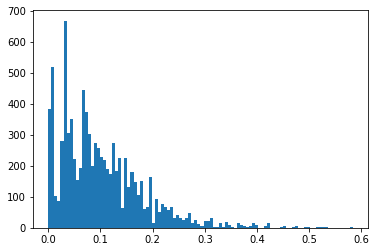

In [500]:
_=plt.hist(loss1,bins=100)

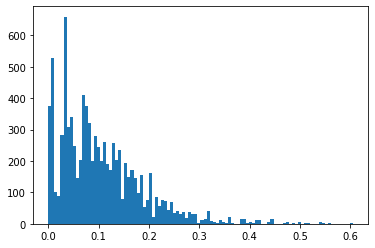

In [501]:
_=plt.hist(loss2,bins=100)

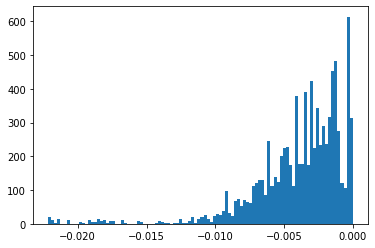

In [499]:
_=plt.hist(lossdiff,bins=100)

In [466]:
loss1 = []
loss2 = []
lossdiff = []
c = 0
t = 0.03232323232323232

k1 = np.random.choice(list(validity))
k2 = np.random.choice(list(validity))

m1 = np.zeros((16,3,2048),dtype='float32')
m2 = np.zeros((16,3,2048),dtype='float32')

for i,w in enumerate(['P', 'QRS', 'T']):
    wave_on = eval("{}on_QTDB".format(w))
    wave_off = eval("{}off_QTDB".format(w))
    for on,off in zip(wave_on[k1],wave_off[k1]):
        on,off = on-validity[k1][0],off-validity[k1][0]
        if on < 2048:
            m1[:,i,on:off] = 1
    for on,off in zip(wave_on[k2],wave_off[k2]):
        on,off = on-validity[k2][0],off-validity[k2][0]
        if on < 2048:
            m2[:,i,on:off] = 1

m1 = torch.tensor(m1).float()#.cuda()
m2 = torch.tensor(m2).float()#.cuda()

for _ in tqdm.tqdm(range(10000)):
    input  = m1[0,c][None,None,].clone()
    target = m2[0,c][None,None,].clone()
    input  = (1-t)*input+t*torch.rand_like(input)
    ls1 = nn.F1InstanceLoss1d(channels=1,threshold=10)(input,target)
    ls2 = F1InstanceLoss1dNew(channels=1,threshold=10)(input,target)
    loss1.append(ls1)
    loss2.append(ls2)
    lossdiff.append(ls1-ls2)

loss1 = np.array(loss1)
loss2 = np.array(loss2)
lossdiff = np.array(lossdiff)

100%|██████████| 10000/10000 [00:25<00:00, 390.25it/s]


In [467]:
print(loss1)
print(loss2)

[0.16718604 0.16694173 0.16734831 ... 0.16738169 0.1671235  0.16851288]
[0.09662493 0.09661243 0.09663305 ... 0.09663606 0.09662209 0.09669224]


In [488]:
linspace = np.linspace(0,0.3,101)
loss1 = []
loss2 = []
lossdiff = []
for t in tqdm.tqdm(linspace):
    loss1.append([])
    loss2.append([])
    lossdiff.append([])
    for _ in range(100):
        input  = m1[0,c][None,None,].clone()
        target = m2[0,c][None,None,].clone()
        input  = (1-t)*input+t*torch.rand_like(input)
        ls1 = nn.F1InstanceLoss1d(channels=1,threshold=10)(input,target)
        ls2 = F1InstanceLoss1dNew(channels=1,threshold=10)(input,target)
        loss1[-1].append(ls1)
        loss2[-1].append(ls2)
        lossdiff[-1].append(ls1-ls2)

loss1 = np.array(loss1)
loss2 = np.array(loss2)
lossdiff = np.array(lossdiff)

100%|██████████| 101/101 [00:19<00:00,  5.26it/s]


0.21


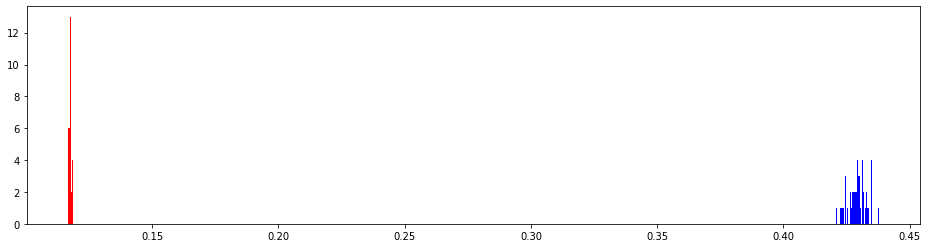

In [494]:
i = 70
print(linspace[i])
plt.figure(figsize=(16,4))
_=plt.hist(loss1[i,:],bins=100,color='b')
_=plt.hist(loss2[i,:],bins=20,color='r')

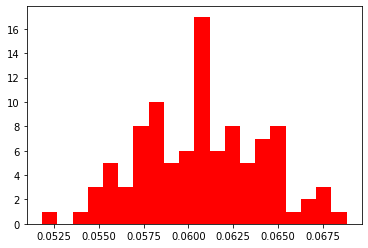

In [428]:
_=plt.hist(loss2[i,:],bins=20,color='r')

In [ ]:
for l1,l2 in zip(loss1,loss2):
    _=plt.hist

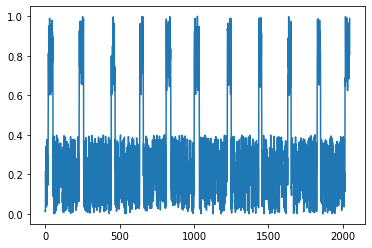

In [412]:
plt.plot(input[0,0,])

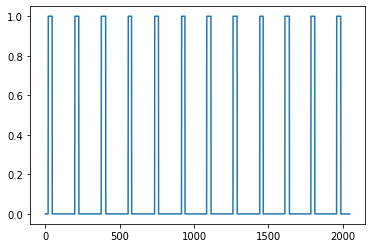

In [354]:
plt.plot(target[0,0,])

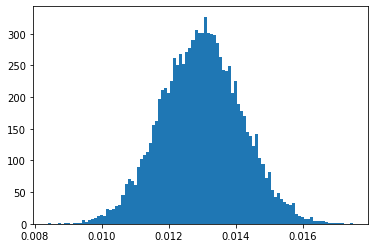

In [355]:
_=plt.hist(loss1,bins=100)

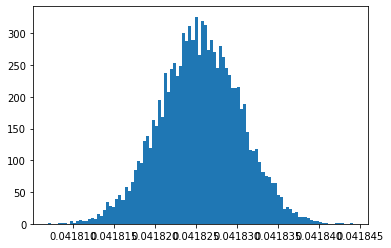

In [356]:
_=plt.hist(loss2,bins=100)

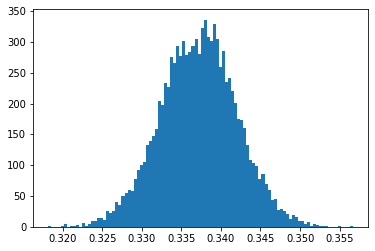

In [348]:
_=plt.hist(lossdiff,bins=100)

In [335]:
ls2

tensor(0.0745)

In [299]:
k1 = np.random.choice(list(validity))
k2 = np.random.choice(list(validity))

m1 = np.zeros((16,3,2048),dtype='float32')
m2 = np.zeros((16,3,2048),dtype='float32')

for i,w in enumerate(['P', 'QRS', 'T']):
    wave_on = eval("{}on_QTDB".format(w))
    wave_off = eval("{}off_QTDB".format(w))
    for on,off in zip(wave_on[k1],wave_off[k1]):
        on,off = on-validity[k1][0],off-validity[k1][0]
        if on < 2048:
            m1[:,i,on:off] = 1
    for on,off in zip(wave_on[k2],wave_off[k2]):
        on,off = on-validity[k2][0],off-validity[k2][0]
        if on < 2048:
            m2[:,i,on:off] = 1
m1 = torch.tensor(m1).float()#.cuda()
m2 = torch.tensor(m2).float()#.cuda()

c = 0
input = m1[0,c][None,None,].clone()
target = m2[0,c][None,None,].clone()
t = 0.05
input = (1-t)*input+t*torch.rand_like(input)
# input[0,0,160:170] += torch.linspace(0,0.5,10)
ls1 = nn.F1InstanceLoss1d(channels=1,threshold=20)(input,target)
ls2 = F1InstanceLoss1dNew(channels=1,threshold=20)(input,target)
print(ls1)
print(ls2)


tensor(0.4817)
tensor(0.1994)


In [249]:
# Move operation to device
self.prewitt = self.prewitt.to(target.device)

# # Obtain sigmoid-ed input and target
# input_sigmoid  = self.sigmoid((input-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible
# target_sigmoid = self.sigmoid((target-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible

# Retrieve boundaries
input_boundary = self.prewitt(input).abs()
target_boundary = self.prewitt(target).abs()

# # Obtain sigmoid-ed input and target
# input_boundary  = self.sigmoid((input_boundary-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible
# target_boundary = self.sigmoid((target_boundary-0.5)*self.threshold) # Rule of thumb for dividing the classes as much as possible

# Sum of elements alongside the spatial dimensions
input_elements = torch.flatten(input_boundary, start_dim=2).sum(-1)/4#-torch.mean(input_boundary)
target_elements = torch.flatten(target_boundary, start_dim=2).sum(-1)/4#-torch.mean(target_boundary)

# Apply class weights
if self.weight is not None:
    # Assert compatible shapes
    assert self.weight.shape[-1] == input.shape[1], "The number of channels and provided class weights does not coincide"
    input_elements = input_elements*self.weight
    target_elements = target_elements*self.weight

# # Hack to get whether target_elements or input_elements is larger
# gate = self.sigmoid((target_elements-input_elements)*self.threshold)

# # Basic metrics
# truepositive  = (target_elements-gate*(target_elements-input_elements)).abs()
# falsepositive = (1-gate)*(input_elements-target_elements).abs()
# falsenegative = gate*(target_elements-input_elements).abs()

# # F1 loss
# loss = 1-(2*truepositive + 1)/(2*truepositive + falsepositive + falsenegative + 1)
# print(self.reduction(loss))
print((target_elements-input_elements).abs()/(target_elements+input_elements))

tensor([[0.6661]])


In [245]:
input_elements

tensor([[43.8929]])

In [240]:
input_elements

tensor([[43.8929]])

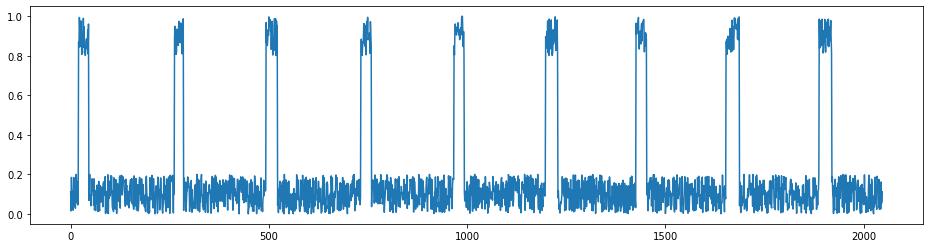

In [250]:
plt.figure(figsize=(16,4))
plt.plot(input[0,0])

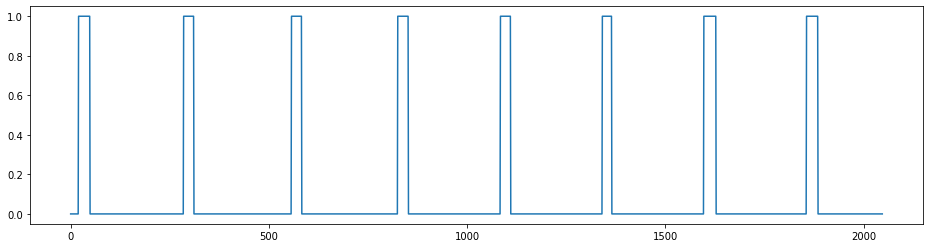

In [251]:
plt.figure(figsize=(16,4))
plt.plot(target[0,0])

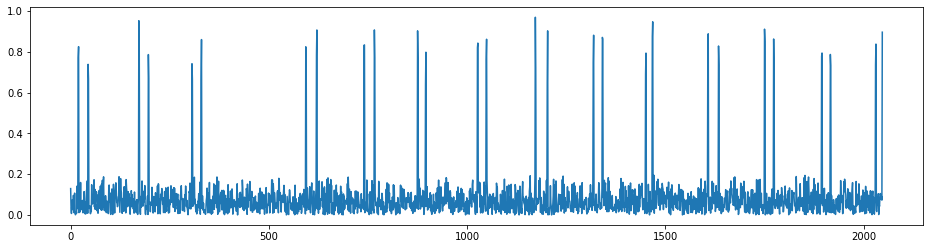

In [234]:
plt.figure(figsize=(16,4))
plt.plot(input_boundary[0,0])

In [235]:
torch.mean(input_boundary)

tensor(0.0857)

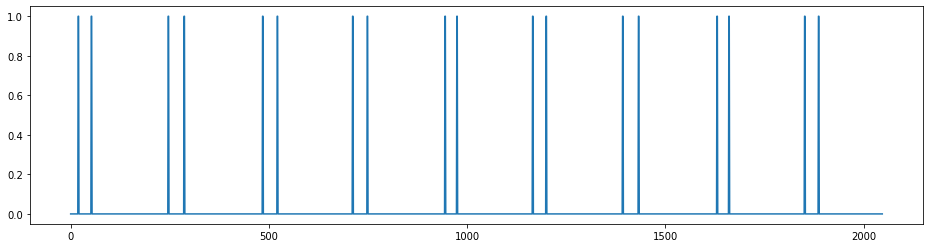

In [236]:
plt.figure(figsize=(16,4))
plt.plot(target_boundary[0,0])

In [163]:
d = 0
intersection = (target_elements-(input_elements+d)).abs()
union = target_elements+(input_elements+d)
intersection/union

tensor([[0.0525]])

In [81]:
intersection

tensor([[9.9995]])

In [82]:
union

tensor([[6.0456]])

In [84]:
ie,te,tp,fp,fn,l = InstanceLossNew(channels=1,threshold=10)(input,target)

In [93]:
nn.Sigmoid()(torch.tensor([[[1.]]]))

tensor([[[0.7311]]])

In [85]:
tp

tensor([[5.6439]])

(tensor([[0.4967]]),
 tensor([[0.4964]]),
 tensor([[0.4964]]),
 tensor([[0.0002]]),
 tensor(0.0005))

In [68]:
te-1.62221*ie

tensor([[6.1035e-05]])

In [71]:
nn.Sigmoid()(te-6*ie)*(te-6*ie)

tensor([[-2.1154e-16]])

In [44]:
(te-ie)

tensor([[5.6533]])

In [ ]:
nn.

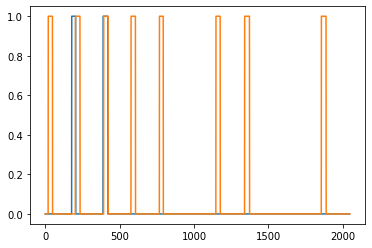

In [32]:
plt.plot(m1[0,c,])
plt.plot(m2[0,c,])

In [23]:
tmp = {
    "class": "sak.torch.nn.CompoundLoss",
    "arguments": 
        {
            "operations": [
            {
                   'class': 'sak.torch.Mapper',
                   'arguments': 
                {
                    'json': {
                        'input_mappings': [['outputs', 'sigmoid'],['inputs', 'y']],
                        'class': 'sak.torch.nn.DiceLoss'
                    }
                }
            },
            {
                   'class': 'sak.torch.Mapper',
                   'arguments': 
                {
                    'json': {
                        'input_mappings': [['outputs', 'sigmoid'],['inputs', 'y']],
                        'class': 'sak.torch.nn.BoundDiceLoss1d'
                    }
                }
            }
        ]
    }
}

In [21]:
# class CompoundLoss:
#     def __init__(self, operations: dict, weights: list = None):
#         self.operations = []
#         self.weights = weights
        
#         for op in operations:
#             # Retrieve operation class
#             cls = sak.class_selector(op['class'])
#             self.operations.append(cls(**op.get('arguments',{})))
            
#         if self.weights is None:
#             self.weights = [1]*len(self.operations)
            
#         assert len(self.operations) == len(self.weights), "The number of provided operations mismatches the size of the provided weights"
            
#     def __call__(self, **kwargs) -> torch.Tensor:
#         loss = 0
        
#         for i in range(len(self.operations)):
#             # add loss to total loss
#             loss += self.weights[i]*self.operations[i](**kwargs)
            
#         return loss



In [ ]:
# class _GridAttentionBlockND_TORR(nn.Module):
#     def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3, mode='concatenation',
#                  sub_sample_factor=(1,1,1), bn_layer=True, use_W=True, use_phi=True, use_theta=True, use_psi=True, nonlinearity1='relu'):
#         super(_GridAttentionBlockND_TORR, self).__init__()

#         assert dimension in [2, 3]
#         assert mode in ['concatenation', 'concatenation_softmax',
#                         'concatenation_sigmoid', 'concatenation_mean',
#                         'concatenation_range_normalise', 'concatenation_mean_flow']

#         # Default parameter set
#         self.mode = mode
#         self.dimension = dimension
#         self.sub_sample_factor = sub_sample_factor if isinstance(sub_sample_factor, tuple) else tuple([sub_sample_factor])*dimension
#         self.sub_sample_kernel_size = self.sub_sample_factor

#         # Number of channels (pixel dimensions)
#         self.in_channels = in_channels
#         self.gating_channels = gating_channels
#         self.inter_channels = inter_channels

#         if self.inter_channels is None:
#             self.inter_channels = in_channels // 2
#             if self.inter_channels == 0:
#                 self.inter_channels = 1

#         if dimension == 3:
#             conv_nd = nn.Conv3d
#             bn = nn.BatchNorm3d
#             self.upsample_mode = 'trilinear'
#         elif dimension == 2:
#             conv_nd = nn.Conv2d
#             bn = nn.BatchNorm2d
#             self.upsample_mode = 'bilinear'
#         else:
#             raise NotImplemented

#         # initialise id functions
#         # Theta^T * x_ij + Phi^T * gating_signal + bias
#         self.W = lambda x: x
#         self.theta = lambda x: x
#         self.psi = lambda x: x
#         self.phi = lambda x: x
#         self.nl1 = lambda x: x

#         if use_W:
#             if bn_layer:
#                 self.W = nn.Sequential(
#                     conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
#                     bn(self.in_channels),
#                 )
#             else:
#                 self.W = conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0)

#         if use_theta:
#             self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
#                                  kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)


#         if use_phi:
#             self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
#                                kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)


#         if use_psi:
#             self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)


#         if nonlinearity1:
#             if nonlinearity1 == 'relu':
#                 self.nl1 = self.relu

#         if 'concatenation' in mode:
#             self.operation_function = self._concatenation
#         else:
#             raise NotImplementedError('Unknown operation function.')


#         if use_psi and self.mode == 'concatenation_sigmoid':
#             nn.init.constant(self.psi.bias.data, 3.0)

#         if use_psi and self.mode == 'concatenation_softmax':
#             nn.init.constant(self.psi.bias.data, 10.0)

#         # if use_psi and self.mode == 'concatenation_mean':
#         #     nn.init.constant(self.psi.bias.data, 3.0)

#         # if use_psi and self.mode == 'concatenation_range_normalise':
#         #     nn.init.constant(self.psi.bias.data, 3.0)

#         parallel = False
#         if parallel:
#             if use_W: self.W = nn.DataParallel(self.W)
#             if use_phi: self.phi = nn.DataParallel(self.phi)
#             if use_psi: self.psi = nn.DataParallel(self.psi)
#             if use_theta: self.theta = nn.DataParallel(self.theta)

#     def forward(self, x, g):
#         '''
#         :param x: (b, c, t, h, w)
#         :param g: (b, g_d)
#         :return:
#         '''

#         output = self.operation_function(x, g)
#         return output

#     def _concatenation(self, x, g):
#         input_size = x.size()
#         batch_size = input_size[0]
#         assert batch_size == g.size(0)

#         #############################
#         # compute compatibility score

#         # theta => (b, c, t, h, w) -> (b, i_c, t, h, w)
#         # phi   => (b, c, t, h, w) -> (b, i_c, t, h, w)
#         theta_x = self.theta(x)
#         theta_x_size = theta_x.size()

#         #  nl(theta.x + phi.g + bias) -> f = (b, i_c, t/s1, h/s2, w/s3)
#         phi_g = F.interpolate(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)

#         f = theta_x + phi_g
#         f = self.nl1(f)

#         psi_f = self.psi(f)

#         ############################################
#         # normalisation -- scale compatibility score
#         #  psi^T . f -> (b, 1, t/s1, h/s2, w/s3)
#         if self.mode == 'concatenation_softmax':
#             sigm_psi_f = F.softmax(psi_f.view(batch_size, 1, -1), dim=2)
#             sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])
#         elif self.mode == 'concatenation_mean':
#             psi_f_flat = psi_f.view(batch_size, 1, -1)
#             psi_f_sum = torch.sum(psi_f_flat, dim=2)#clamp(1e-6)
#             psi_f_sum = psi_f_sum[:,:,None].expand_as(psi_f_flat)

#             sigm_psi_f = psi_f_flat / psi_f_sum
#             sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])
#         elif self.mode == 'concatenation_mean_flow':
#             psi_f_flat = psi_f.view(batch_size, 1, -1)
#             ss = psi_f_flat.shape
#             psi_f_min = psi_f_flat.min(dim=2)[0].view(ss[0],ss[1],1)
#             psi_f_flat = psi_f_flat - psi_f_min
#             psi_f_sum = torch.sum(psi_f_flat, dim=2).view(ss[0],ss[1],1).expand_as(psi_f_flat)

#             sigm_psi_f = psi_f_flat / psi_f_sum
#             sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])
#         elif self.mode == 'concatenation_range_normalise':
#             psi_f_flat = psi_f.view(batch_size, 1, -1)
#             ss = psi_f_flat.shape
#             psi_f_max = torch.max(psi_f_flat, dim=2)[0].view(ss[0], ss[1], 1)
#             psi_f_min = torch.min(psi_f_flat, dim=2)[0].view(ss[0], ss[1], 1)

#             sigm_psi_f = (psi_f_flat - psi_f_min) / (psi_f_max - psi_f_min).expand_as(psi_f_flat)
#             sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])

#         elif self.mode == 'concatenation_sigmoid':
#             sigm_psi_f = self.sigmoid(psi_f)
#         else:
#             raise NotImplementedError

#         # sigm_psi_f is attention map! upsample the attentions and multiply
#         sigm_psi_f = F.interpolate(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
#         y = sigm_psi_f.expand_as(x) * x
#         W_y = self.W(y)

#         return W_y, sigm_psi_f


# class GridAttentionBlock2D_TORR(_GridAttentionBlockND_TORR):
#     def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
#                  sub_sample_factor=(1,1), bn_layer=True,
#                  use_W=True, use_phi=True, use_theta=True, use_psi=True,
#                  nonlinearity1='relu'):
#         super(GridAttentionBlock2D_TORR, self).__init__(in_channels,
#                                                inter_channels=inter_channels,
#                                                gating_channels=gating_channels,
#                                                dimension=2, mode=mode,
#                                                sub_sample_factor=sub_sample_factor,
#                                                bn_layer=bn_layer,
#                                                use_W=use_W,
#                                                use_phi=use_phi,
#                                                use_theta=use_theta,
#                                                use_psi=use_psi,
#                                                nonlinearity1=nonlinearity1)




In [16]:
import torch.nn.functional as F

class _GridAttentionBlockND(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(_GridAttentionBlockND, self).__init__()

        assert dimension in [2, 3]
        assert mode in ['concatenation', 'concatenation_debug', 'concatenation_residual']

        # Downsampling rate for the input featuremap
        if isinstance(sub_sample_factor, tuple): self.sub_sample_factor = sub_sample_factor
        elif isinstance(sub_sample_factor, list): self.sub_sample_factor = tuple(sub_sample_factor)
        else: self.sub_sample_factor = tuple([sub_sample_factor]) * dimension

        # Default parameter set
        self.mode = mode
        self.dimension = dimension
        self.sub_sample_kernel_size = self.sub_sample_factor
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)
        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(dim=2)

        # Number of channels (pixel dimensions)
        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = max([in_channels // 2,1])

        if dimension == 3:
            conv_nd = nn.Conv3d
            bn = nn.BatchNorm3d
            self.upsample_mode = 'trilinear'
        elif dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        # Theta^T * x_ij + Phi^T * gating_signal + bias
        self.Wx = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)
        self.Wg = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0, bias=True)
        self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        # Define the operation
        if mode == 'concatenation':
            self.operation_function = self._concatenation
        elif mode == 'concatenation_debug':
            self.operation_function = self._concatenation_debug
        elif mode == 'concatenation_residual':
            self.operation_function = self._concatenation_residual
        else:
            raise NotImplementedError('Unknown operation function.')


    def forward(self, x, g):
        '''
        :param x: (b, c, t, h, w)
        :param g: (b, g_d)
        :return:
        '''

        output = self.operation_function(x, g)
        return output

    def _concatenation(self, input, gate):
        assert input.size(0) == gate.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        downsampled_input = self.Wx(input)

        # gate (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(downsampled_input + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        pointwise_gate = self.Wg(gate)
        pointwise_gate = F.interpolate(pointwise_gate, size=downsampled_input.size()[2:], mode=self.upsample_mode)
        input_psi = self.relu(downsampled_input + pointwise_gate)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        output_psi = self.sigmoid(self.psi(input_psi))

        # upsample the attentions and multiply
        sigm_psi_f = F.interpolate(output_psi, size=input.shape[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(input) * input

        return y, sigm_psi_f

    def _concatenation_residual(self, input, gate):
        assert input.size(0) == gate.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        downsampled_input = self.Wx(input)

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        pointwise_gate = self.Wg(gate)
        pointwise_gate = F.interpolate(pointwise_gate, size=downsampled_input.shape[2:], mode=self.upsample_mode)
        input_psi = self.relu(downsampled_input + pointwise_gate)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        f = self.psi(input_psi).view(input.size(0), 1, -1)
        output_psi = self.softmax(f).view(batch_size, 1, *theta_x.size()[2:])

        # upsample the attentions and multiply
        sigm_psi_f = F.interpolate(output_psi, size=input.shape[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x

        return y, sigm_psi_f


class GridAttentionBlock2D(_GridAttentionBlockND):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(2,2)):
        super(GridAttentionBlock2D, self).__init__(in_channels,
                                                   inter_channels=inter_channels,
                                                   gating_channels=gating_channels,
                                                   dimension=2, mode=mode,
                                                   sub_sample_factor=sub_sample_factor,
                                                   )

In [17]:
self = GridAttentionBlock2D(8,16)
x = torch.rand(8,8,64,64)
g = torch.rand(8,16,32,32)

In [18]:
out = self(x,g)

In [19]:
out[0].shape

torch.Size([8, 8, 64, 64])

In [20]:
out[1].shape

torch.Size([8, 1, 64, 64])

In [21]:
self.W

Sequential(
  (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [22]:
self.theta

Conv2d(8, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)

In [23]:
self.phi

Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))

In [24]:
self.psi

Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))

In [25]:
self.theta

Conv2d(8, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)

In [25]:
cls = sak.class_selector(tmp['class'])
self = cls(**tmp['arguments'])

In [26]:
self(inputs={"y": m1},outputs={"sigmoid": m2})

tensor(1.3943, device='cuda:0')

In [27]:
nn.CompoundLoss(losses)

TypeError: __init__() got an unexpected keyword argument 'weights'

In [179]:
out[-1][0,0,:].cpu().numpy()

16.0

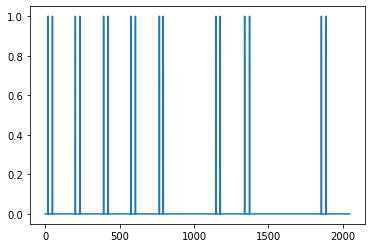

In [177]:
plt.plot(out[-1][0,0,:].cpu().numpy())

In [172]:
tmp = torch.rand(16,4,2048)

In [175]:
nn.AdaptiveAvgPool1d(1)

torch.Size([16, 4, 1])

In [171]:
nn.Parallel((nn.Identity(),nn.Sequential()))

NameError: name 'Parallel' is not defined

In [5]:
tmp = execution['model']['nodes'][0]['arguments']['regularization']

In [6]:
tmp[1]['arguments']['num_features'] = 16

In [19]:
import itertools

In [26]:
def soft_argmax(voxels):
    """
    Arguments: voxel patch in shape (batch_size, channel, H, W, depth)
    Return: 3D coordinates in shape (batch_size, channel, 3)
    """
    # alpha is here to make the largest element really big, so it
    # would become very close to 1 after softmax
    alpha = 1000.0 
    N = voxels.shape[0]
    C = voxels.shape[1]
    R = voxels.shape[2:]
    soft_max = nn.functional.softmax(voxels.view(N,C,-1)*alpha,dim=2)
    soft_max = soft_max.view(voxels.shape)
    indices_kernel = torch.arange(start=0,end=math.prod(R)).unsqueeze(0)
    indices_kernel = indices_kernel.view(R)
    conv = soft_max*indices_kernel
    indices = conv.sum(2)
    while indices.dim() > 2:
        indices = indices.sum(2)
    coords = []
    for i,dim in enumerate(R):
        coords.append(indices%dim)
        if i < len(R)-1:
            indices = (indices/R[i+1]).floor()
    coords = torch.stack(coords[::-1],dim=2)
    return coords



In [30]:
segmentation = input['y']
signal = input['x']

In [31]:
tmp = soft_argmax(signal)

In [33]:
tmp.long()

tensor([[[ 156]],

        [[ 832]],

        [[ 270]],

        [[1199]],

        [[ 686]],

        [[1525]],

        [[1066]],

        [[ 864]],

        [[ 729]],

        [[1394]],

        [[ 214]],

        [[1348]],

        [[1463]],

        [[1091]],

        [[ 276]],

        [[ 232]],

        [[1480]],

        [[1855]],

        [[ 850]],

        [[1645]],

        [[ 797]],

        [[1996]],

        [[1939]],

        [[1237]],

        [[1639]],

        [[1648]],

        [[1692]],

        [[  57]],

        [[ 665]],

        [[1161]],

        [[1549]],

        [[1301]],

        [[1407]],

        [[ 531]],

        [[1039]],

        [[1649]],

        [[1397]],

        [[ 197]],

        [[ 823]],

        [[1497]],

        [[1695]],

        [[1750]],

        [[ 875]],

        [[ 752]],

        [[ 353]],

        [[1879]],

        [[ 992]],

        [[ 227]],

        [[1052]],

        [[1106]],

        [[ 517]],

        [[1325]],

        [[ 2

In [142]:
from typing import Callable

In [147]:
isinstance(torch.float32, Callable)

False

In [136]:
loss = sak.class_selector(execution["loss"]["class"])(**execution["loss"]["arguments"])
print(loss(inputs={"y": torch.rand(16,3,2048)}, outputs={"sigmoid": torch.rand(16,3,2048)}))
print("")

augm = sak.class_selector(execution["augmentation"]["class"])(**execution["augmentation"]["arguments"])
inp = {"x": torch.rand(16,1,2048)}
inp_pre = {k: torch.clone(inp[k]) for k in inp}
print(torch.allclose(inp["x"],inp_pre["x"]))
augm(inputs=inp)
print(torch.allclose(inp["x"],inp_pre["x"]))

tensor(0.5000)

True
False


In [4]:
self = nn.ModelGraph(execution['model']).float()

In [6]:
self({"x": torch.rand(16,1,2048),"noise": torch.rand(16,64,512)})

{'sigmoid': tensor([[[0.5725, 0.5884, 0.5554,  ..., 0.5585, 0.5539, 0.5712],
          [0.3596, 0.3814, 0.4062,  ..., 0.4384, 0.4281, 0.3786],
          [0.6348, 0.6288, 0.6472,  ..., 0.6191, 0.6307, 0.6152]],
 
         [[0.5722, 0.5561, 0.5773,  ..., 0.5666, 0.5355, 0.6068],
          [0.3988, 0.3768, 0.3450,  ..., 0.3338, 0.3445, 0.2628],
          [0.6155, 0.6175, 0.6053,  ..., 0.5900, 0.5809, 0.6011]],
 
         [[0.6060, 0.6071, 0.5889,  ..., 0.6082, 0.5968, 0.5944],
          [0.3863, 0.3570, 0.2927,  ..., 0.2946, 0.3187, 0.3349],
          [0.6241, 0.6186, 0.5986,  ..., 0.5851, 0.6092, 0.6126]],
 
         ...,
 
         [[0.5553, 0.6535, 0.5028,  ..., 0.5503, 0.5461, 0.5455],
          [0.4172, 0.3634, 0.4547,  ..., 0.4949, 0.4877, 0.4351],
          [0.6290, 0.6259, 0.6279,  ..., 0.5875, 0.5788, 0.5829]],
 
         [[0.5691, 0.6075, 0.5839,  ..., 0.4999, 0.4182, 0.4407],
          [0.3893, 0.3713, 0.4041,  ..., 0.5056, 0.6192, 0.6270],
          [0.6195, 0.6332, 0.6308,  .

In [74]:
# 1. Compute all simple paths from all list of inputs to the specific output
nodes_path = []
for input in inputs:
    nodes_path.append(networkx.all_simple_paths(self.graph, input, output))

# 2. Determine all necessary nodes for that specific output
nodes_path = set(itertools.chain(*itertools.chain(*nodes_path)))

# 2. Obtain subgraph
subgraphs = [networkx.DiGraph(self.graph.subgraph(nodes_path))]

# 3. Order topologically the subset of nodes
all_executions = [list(networkx.topological_sort(subgraphs[-1]))]


In [75]:
all_executions

[['decoder_1_lvl2',
  'decoder_1_upsample2',
  ('decoder_1_upsample2', 'encoder_1_lvl1'),
  'decoder_1_concat1',
  'decoder_1_lvl1',
  'encoder_2_lvl1',
  'encoder_2_avgpool1',
  ('encoder_1_lvl2', 'encoder_2_avgpool1'),
  'encoder_2_concat2',
  'encoder_2_lvl2',
  'encoder_2_avgpool2',
  ('encoder_1_lvl3', 'encoder_2_avgpool2'),
  'encoder_2_concat3',
  'encoder_2_lvl3',
  'encoder_2_avgpool3',
  ('encoder_1_lvl4', 'encoder_2_avgpool3'),
  'encoder_2_concat4',
  'encoder_2_lvl4',
  'encoder_2_avgpool4',
  ('encoder_1_lvl5', 'encoder_2_avgpool4'),
  'encoder_2_concat5',
  'encoder_2_lvl5',
  'decoder_2_upsample5',
  ('decoder_2_upsample5', 'encoder_2_lvl4'),
  'decoder_2_concat4',
  'decoder_2_lvl4',
  'decoder_2_upsample4',
  ('decoder_2_upsample4', 'encoder_2_lvl3'),
  'decoder_2_concat3',
  'decoder_2_lvl3',
  'decoder_2_upsample3',
  ('decoder_2_upsample3', 'encoder_2_lvl2'),
  'decoder_2_concat2',
  'decoder_2_lvl2',
  'decoder_2_upsample2',
  ('decoder_2_upsample2', 'encoder_2_lv

In [5]:
json = execution['model']

In [22]:
# Compose network
self.graph = networkx.DiGraph()

# Retrieve output list for forward function
self.__return_list = []
for function in json['functions']:
    if function['name'] == 'forward':
        self.__return_list += function['outputs']

# Add nodes to graph
for node in json['nodes']:
    does_node_return = node['id'] in self.__return_list
    self.graph.add_node(node['id'], returns=does_node_return)
    # Selected class
    cls = sak.class_selector(node['class'])
    # Add instantiated class to modules
    self.add_module(node['id'], cls(**node.get('arguments',{})))

# Add edges to graph
for edge_from, edge_to in json['edges']:
    # Convert to tuples (list not acceptable as identifiers)
    if isinstance(edge_from, list):
        edge_from = tuple(edge_from)
    if isinstance(edge_to, list):
        edge_to = tuple(edge_to)

    # Add edges between nodes
    self.graph.add_edge(edge_from, edge_to)


In [23]:
# Set output computational flows
self.output_paths = {}
self.subgraphs = {}
for function in json['functions']:
    # Retrieve paths
    all_executions = []
    subgraphs = []

    for output in function['outputs']:
        if len(function['inputs']) > 1:
            raise NotImplementedError("Not yet implemented for more than one input per function")
        else:
            input = function['inputs'][0]

        # 1. Determine all necessary nodes for that specific output
        nodes_path = set([n for l in list(networkx.all_simple_paths(self.graph,input,output)) for n in l])
        # 2. Obtain subgraph
        subgraphs.append(networkx.DiGraph(self.graph.subgraph(nodes_path)))
        # 3. Order topologically the subset of nodes
        all_executions.append(list(networkx.topological_sort(subgraphs[-1])))

    self.subgraphs[function['name']] = subgraphs
    self.output_paths[function['name']] = all_executions

    # Set function
    agjalgj
    self.compose(function['name'],function['inputs'],function['outputs'])


NameError: name 'agjalgj' is not defined

In [82]:
name,start_nodes,end_nodes = function['name'],function['inputs'],function['outputs']

In [80]:
for function in execution["model"]['functions']:
    pass

['y']

In [25]:
# Retrieve function call with provided name. Static 
# starting node (hence the difference between calls)
# List end nodes as array (for comparison)
if isinstance(start_nodes, list):
    start_nodes = tuple(start_nodes)
if isinstance(end_nodes,list):
    end_nodes = np.array(end_nodes)
else:
    end_nodes = np.array([end_nodes])

# Retrieve execution information
all_executions = self.output_paths[name]
subgraphs = self.subgraphs[name]

In [63]:
input = {"x": torch.rand(16,1,2048)}

In [60]:
from typing import Dict

In [67]:
all_executions

[[]]

In [64]:
# Iterate over paths
if not isinstance(input, Dict):
    raise ValueError("Only accepts a dict of torch tensors as input")
# Define output structures
partial = {}
output = {}

# Add inputs to "performed" computations
partial.update(input)

# Iterate over all network paths that lead to specific tensors marked as outputs
# The "execution_order" variable is the one that carries the weight - has information
# of the execution path from the input nodes to the output nodes ordered so that,
# during the loop, you never need a partial result that has not been computed beforehand.
for i,(execution_order,subgraph) in enumerate(zip(all_executions,subgraphs)):
    # Iterate over execution output path, from input node (no parents)
    for j,node_to in enumerate(execution_order):
        # Check if node_to has already been computed (e.g. inputs)
        if node_to in partial:
            continue

        # Check all parent nodes, ordered topologically
        nodes_from = tuple(subgraph.predecessors(node_to))
        # If a single node is contained, mark to be computed
        if len(nodes_from) == 1:
            nodes_from = nodes_from[0]

        # Prepare inputs
        if isinstance(nodes_from, tuple):
            x = []
            for n in nodes_from:
                x.append(partial[n])
            x = tuple(x)
        else:
            x = (partial[nodes_from],)

        # Compute output
        # If node_to is tuple, merging point of parallel/concatenation/etc
        # branches (no operation to be performed in that case)
        if not isinstance(node_to, tuple):
            partial[node_to] = self[node_to](*x)

    # The last node computed is always a terminal node, and is added to the output list
    output[node_to] = partial[node_to]


TypeError: forward() missing 1 required positional argument: 'x'

In [42]:
output = model(input['x'])

In [45]:
output['sigmoid'].shape

torch.Size([64, 3, 2048])

In [48]:
from typing import Dict

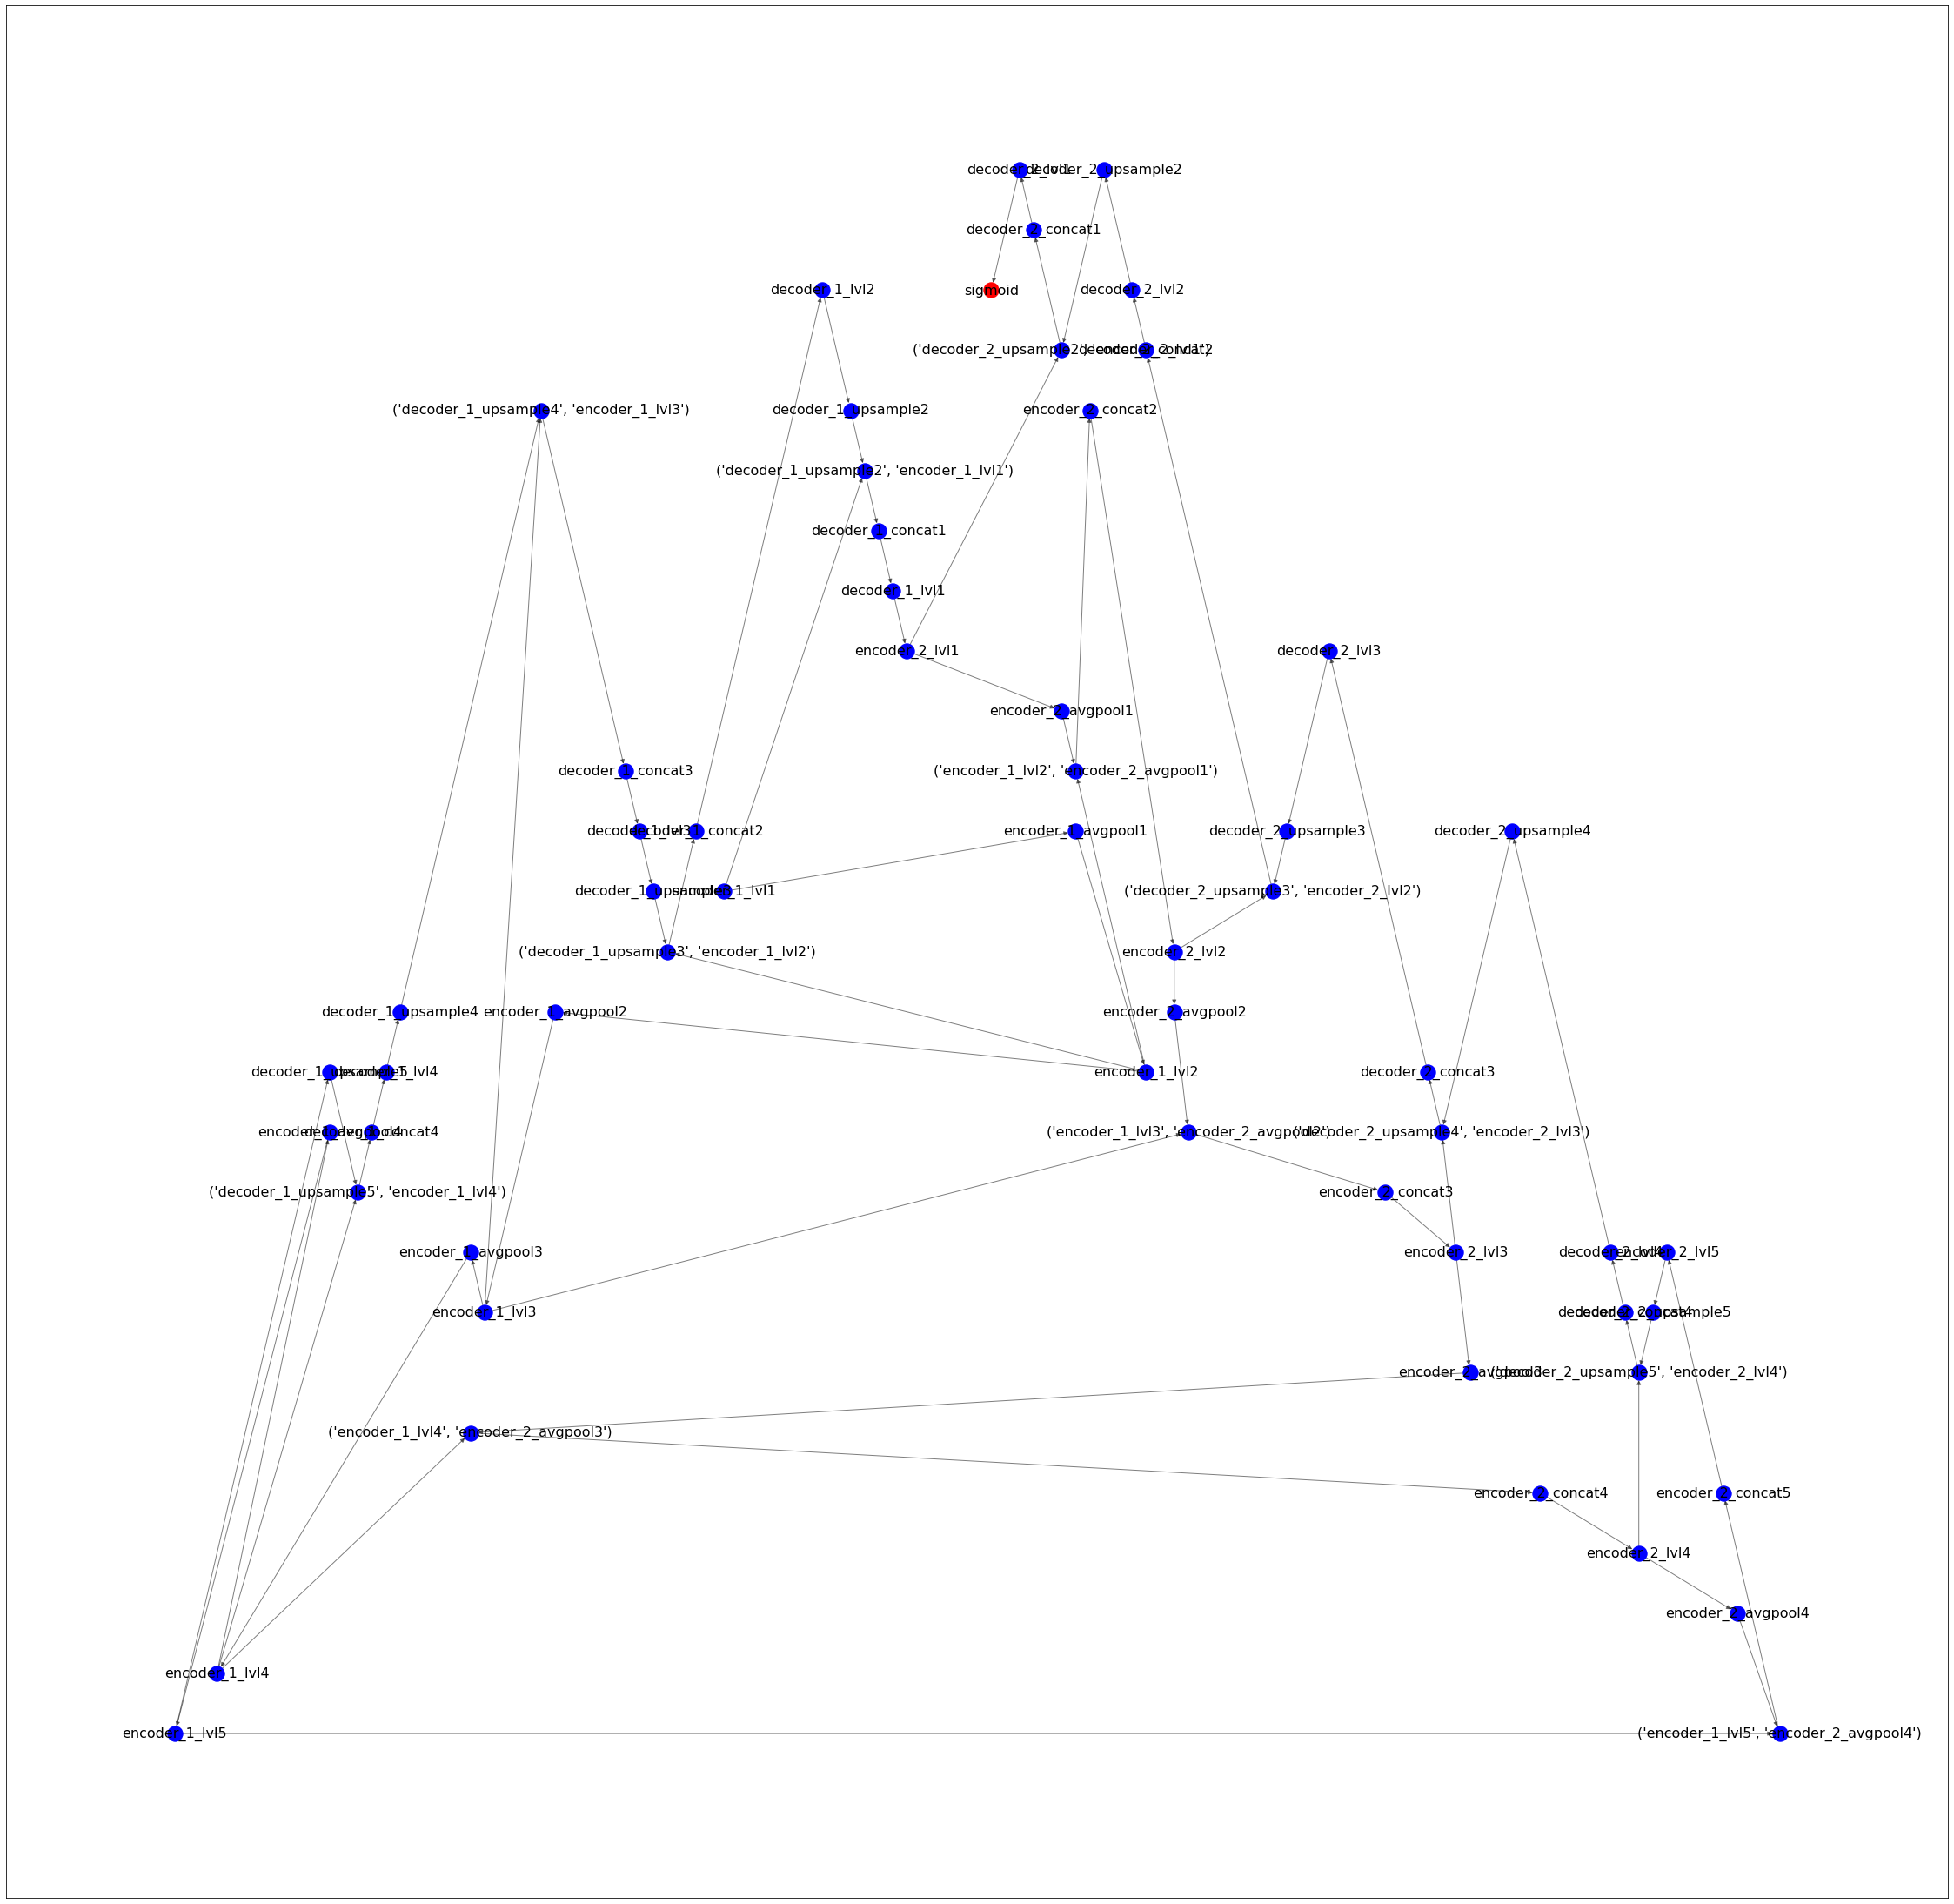

In [47]:
plt.figure(figsize=(40,40))
model.draw_networkx()
plt.savefig("aaa.svg")

In [16]:
out['x'].shape

torch.Size([64, 1, 2048])

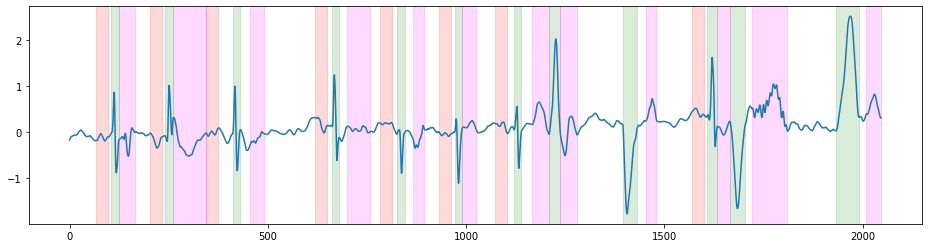

In [15]:
i = 20
sak.visualization.plot.segmentation(out['x'][i,0,:],out['y'][i,])

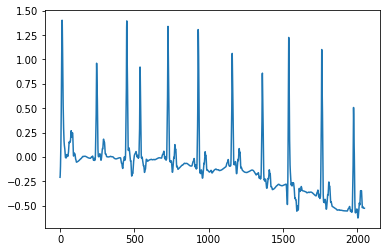

In [30]:
fig = plt.figure()
plt.plot(out['x'][0,0,:])
# plt.plot(out['y'][0,0,:])
tmp = plt.gca()

In [28]:
import matplotlib

In [29]:
isinstance(tmp, matplotlib.axes.Axes)

True

In [27]:
type(tmp)

matplotlib.axes._subplots.AxesSubplot

In [4]:
# Define model
model = sak.from_dict(execution["model"]).float()

In [6]:
x = torch.rand(16,1,2048)
out = model(x)
out

In [12]:
dataset_train = src.data.Dataset(Ptrain, QRStrain, Ttrain, PQtrain, STtrain, TPtrain, 
                                 Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                 STdistribution, TPdistribution, **execution['dataset'])
dataset_valid = src.data.Dataset(Pvalid, QRSvalid, Tvalid, PQvalid, STvalid, TPvalid, 
                                 Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                 STdistribution, TPdistribution, **execution['dataset'])

# Create dataloaders
loader_train = torch.utils.data.DataLoader(dataset_train,**execution['loader'])
loader_valid = torch.utils.data.DataLoader(dataset_valid,**execution['loader'])

In [2]:
import ast

In [5]:
%%timeit
eval("lambda X,y,y_pred: sak.torch.nn.DiceLoss()(y_pred, y)")

11.7 µs ± 95.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
### Loss
# criterion = lambda X,y,y_pred: sak.torch.nn.CrossEntropyLoss()(y_pred, y.long())
# metric = lambda X,y,y_pred: sak.torch.nn.CrossEntropyLoss()(y_pred, y.long())
criterion = lambda X,y,y_pred: sak.torch.nn.DiceLoss()(y_pred, y)
metric = lambda X,y,y_pred: sak.torch.nn.DiceLoss()(y_pred, y)

state = {
    'epoch'         : 0,
    'device'        : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'optimizer'     : sak.class_selector('torch.optim',execution['optimizer']['class'])(model.parameters(), **execution['optimizer']['arguments']),
    'root_dir'      : './'
}
if 'scheduler' in execution:
    state['scheduler'] = sak.class_selector('torch.optim.lr_scheduler',execution['scheduler']['class'])(state['optimizer'], **execution['scheduler']['arguments'])

# Save model-generating files
shutil.copyfile('./src/data.py',os.path.join(execution['save_directory'],'data.py'))
shutil.copyfile('./src/metrics.py',os.path.join(execution['save_directory'],'metrics.py'))
shutil.copyfile(config_file,os.path.join(execution['save_directory'],os.path.split(config_file)[1]))

# Train model (auto-saves to same location as above)
state = sak.torch.train.train_model(model,
                                      state,
                                      execution,
                                      loader_train,
                                      loader_valid,
                                      criterion,
                                      metric,
                                      smaller=True)

(Valid) Epoch  91/100, Loss      0.119: 100%|██████████| 512/512 [04:03<00:00,  2.11it/s]


(Valid) Epoch 100/100, Loss      0.101: 100%|██████████| 512/512 [04:49<00:00,  1.77it/s]


In [13]:
list(set([k.split('###')[0] for k in valid_keys]))

['SOO60-1-1_AVR',
 '12_V4',
 'SOO61-1-1_V5',
 'SOO51-1-1_V1',
 'SOO41-1-1_AVF',
 '40_AVF',
 'SOO58-1-1_V2',
 '37_AVR',
 'SOO50-1-1_III',
 '22_I',
 'SOO27-1-1_AVL',
 '42_V1',
 'SOO58-1-1_V4',
 'SOO69-1-1_AVF',
 'SOO31-1-1_V6',
 '4_V4',
 'SOO59-1-1_V6',
 'SOO46-1-1_V1',
 '7_V3',
 '13_AVR',
 '16_AVL',
 'SOO39-1-1_V2',
 '28_V3',
 'SOO18-1-1_III',
 '4_AVR',
 'SOO10-1-1_AVF',
 'SOO13-1-1_AVR',
 'SOO20-1-1_V4',
 'SOO43-1-1_V4',
 '41_I',
 'SOO21-1-1_II',
 '36_I',
 '24_II',
 '26_V2',
 'SOO2-1-1_V3',
 'SOO23-1-1_AVL',
 'SOO32-1-1_V1',
 'SOO41-1-1_V3',
 'SOO55-1-1_V2',
 'SOO44-1-1_V3',
 'SOO18-1-1_AVF',
 '2_III',
 '6_V6',
 '18_AVR',
 '41_V6',
 'SOO52-1-1_AVL',
 'SOO15-1-1_V6',
 'SOO63-1-1_AVR',
 '7_V6',
 '41_V5',
 'SOO44-1-1_V2',
 '46_I',
 'SOO24-1-1_III',
 '32_AVL',
 '28_II',
 'SOO32-1-1_V3',
 'SOO4-1-1_AVF',
 'SOO21-1-1_I',
 'SOO43-1-1_AVL',
 '25_V2',
 '32_V4',
 'SOO21-1-1_AVF',
 '36_V5',
 'SOO8-1-1_III',
 'SOO19-1-1_AVR',
 'SOO55-1-1_III',
 'SOO55-1-1_V1',
 'SOO63-1-1_III',
 '33_V5',
 '22_III'

In [14]:
%%time
for x,y in loader_valid:
    break

CPU times: user 19 ms, sys: 64 ms, total: 82.9 ms
Wall time: 3.26 s


In [15]:
agkljjsgkldjs

NameError: name 'agkljjsgkldjs' is not defined

In [ ]:
(out,) = model(x.cuda())
y2 = torch.clone(y)
y = torch.zeros((64,3,2048),dtype=bool)
y[:,0,:] = (y2 == 1)
y[:,1,:] = (y2 == 2)
y[:,2,:] = (y2 == 3)

In [ ]:
i = 2
w = 3
plt.figure(figsize=(15,5))
plt.plot(x[i,0,:])
plt.twinx()
plt.plot(y[i,w-1,:],alpha=0.5)
plt.plot(out[i,w,:].cpu().detach().numpy(),alpha=0.5)


# Test against SoO db

In [ ]:
with open('./configurations/UNet5Levels.json', 'r') as f:
    execution = json.load(f)

# Define model
# model = sak.from_dict(execution["model"]).float().cuda()
model = torch.load('/home/guille/GitHub/DelineatorSwitchAndCompose/Notebooks/modelo5nivsdice.state',pickle_module=dill).eval().float()
# model = torch.load(os.path.join(execution['save_directory'],'modelo5nivsdiceversion6_3','model_best.model'),pickle_module=dill).eval().float()
# model = torch.load(os.path.join(execution['save_directory'],'modelo5nivsdiceversion6_3','checkpoint.model'),pickle_module=dill).eval().float()

In [ ]:
#### LOAD DATASET ####
basedir = '/media/guille/DADES/DADES/Delineator/'
Files = os.listdir(os.path.join(basedir,'SoO','RETAG'))
Files = [os.path.splitext(f)[0] for f in Files if os.path.splitext(f)[1] == '.txt']
Segmentations = pd.read_csv(os.path.join(basedir,'SoO','SEGMENTATIONS.csv'),index_col=0,header=None).T
Keys = Segmentations.keys().tolist()
Keys = [k for k in Keys if '-'.join(k.split('-')[:2]) in Files]
database = pd.read_csv(os.path.join(basedir,'SoO','DATABASE_MANUAL.csv'))

# Data storage
QRSsignalSoO = dict()
QRSgroupSoO = dict()

for k in tqdm.tqdm(Keys):
    # Retrieve general information
    fname = '-'.join(k.split('-')[:2]) + '.txt'
    ID = int(k.split('-')[0])
    
    # Read signal and segmentation
    Signal = pd.read_csv(os.path.join(basedir,'SoO','RETAG',fname),index_col=0).values
    (son,soff) = Segmentations[k]
    fs = database['Sampling_Freq'][database['ID'] == int(ID)].values[0]
    
    # Check correct segmentation
    if son > soff:
        print("(!!!) Check file   {:>10s} has onset ({:d}) > offset ({:d})".format(k, son, soff))
        continue

    # Up/downsample to 1000 Hz
    factor = int(fs/250)
    Signal = np.round(sp.signal.decimate(Signal.T, factor)).T
    fs = fs/factor

    # Filter baseline wander and high freq. noise
    Signal = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/fs, 'high'),Signal.T).T
    Signal = sp.signal.filtfilt(*sp.signal.butter(4, 125.0/fs,  'low'),Signal.T).T
    
    for i in range(len(StandardHeader)):
        # Store data
        QRSsignalSoO[k+'###'+str(StandardHeader[i])] = Signal[:,i]


In [ ]:
tmp = QRSsignalSoO['49-1-1###III']
ampl = np.median(sak.signal.moving_lambda(tmp,200,lambda x: np.max(x)-np.min(x)))
# tmp = scipy.interpolate.interp1d(np.linspace(0,1,tmp.size),tmp)(np.linspace(0,1,tmp.size))
aaa = (skimage.util.view_as_windows(tmp/ampl,2048,1024)-0)[:,None,:]
bbb = torch.zeros((aaa.shape[0],3,2048),dtype=float)
for i in range(0,aaa.shape[0],64):
    bbb[i:i+64] = model(torch.tensor(aaa[i:i+64]).cuda().float())[0]
bbb = bbb.cpu().detach().numpy()

i = 0
w = 0
f,ax = plt.subplots(nrows=3,figsize=(15,10))
ax[0].plot(aaa[i,0,:])
ax1 = ax[0].twinx()
ax1.plot(bbb[i,0,:]>0.5,alpha=0.5,color='red')
ax[1].plot(aaa[i,0,:])
ax2 = ax[1].twinx()
ax2.plot(bbb[i,1,:]>0.5,alpha=0.5,color='green')
ax[2].plot(aaa[i,0,:])
ax3 = ax[2].twinx()
ax3.plot(bbb[i,2,:]>0.5,alpha=0.5,color='magenta')


# Test against LUDB

In [ ]:
LUDBsignal = {}

for i in tqdm.tqdm(range(200)):
    (signal, header) = wfdb.rdsamp(os.path.join(basedir,'ludb','{}'.format(i+1)))
    sortOrder = np.where(np.array([x.upper() for x in header['sig_name']])[:,None] == StandardHeader)[1]
    signal = signal[:,sortOrder]
    signal = sp.signal.decimate(signal,header['fs']//250,axis=0)
    
    for j in range(len(StandardHeader)):
        lead = StandardHeader[j]
        name = str(i+1)+"###"+lead
        LUDBsignal[name] = signal[:,j]

LUDBsignal = pd.DataFrame(LUDBsignal)

In [ ]:
list(set([k.split('###')[0] for k in valid_keys]))

In [ ]:
tmp = LUDBsignal['39###AVL']
ampl = np.median(sak.signal.moving_lambda(tmp,200,lambda x: np.max(x)-np.min(x)))
tmp = scipy.interpolate.interp1d(np.linspace(0,1,tmp.size),tmp)(np.linspace(0,1,1.0*tmp.size))
aaa = (skimage.util.view_as_windows(tmp/ampl,2048,1024)-0)[:,None,:]
bbb = torch.zeros((aaa.shape[0],3,2048),dtype=float)
for i in range(0,aaa.shape[0],64):
    bbb[i:i+64] = model(torch.tensor(aaa[i:i+64]).cuda().float())[0]
bbb = bbb.cpu().detach().numpy()

i = 0
w = 0
f,ax = plt.subplots(nrows=3,figsize=(15,10))
ax[0].plot(aaa[i,0,:])
ax1 = ax[0].twinx()
ax1.plot(bbb[i,0,:]>0.5,alpha=0.5,color='red')
ax[1].plot(aaa[i,0,:])
ax2 = ax[1].twinx()
ax2.plot(bbb[i,1,:]>0.5,alpha=0.5,color='green')
ax[2].plot(aaa[i,0,:])
ax3 = ax[2].twinx()
ax3.plot(bbb[i,2,:]>0.5,alpha=0.5,color='magenta')


# Test against QTDB

In [ ]:
QTDBsignal = pd.read_csv(os.path.join(basedir,'QTDB','Dataset.csv'), index_col=0)
QTDBsignal = dataset.sort_index(axis=1)

In [ ]:
list(set([k.split('###')[0] for k in valid_keys]))

In [ ]:
tmp = QTDBsignal['sel16272_0']
ampl = np.median(sak.signal.moving_lambda(tmp,200,lambda x: np.max(x)-np.min(x)))
tmp = scipy.interpolate.interp1d(np.linspace(0,1,tmp.size),tmp)(np.linspace(0,1,1.0*tmp.size))
aaa = (skimage.util.view_as_windows(tmp/ampl,2048,1024)-0)[:,None,:]
bbb = torch.zeros((aaa.shape[0],3,2048),dtype=float)
for i in range(0,aaa.shape[0],64):
    bbb[i:i+64] = model(torch.tensor(aaa[i:i+64]).cuda().float())[0]
bbb = bbb.cpu().detach().numpy()

i = 74
w = 0
f,ax = plt.subplots(nrows=3,figsize=(15,10))
ax[0].plot(aaa[i,0,:])
ax1 = ax[0].twinx()
ax1.plot(bbb[i,0,:]>0.5,alpha=0.5,color='red')
ax[1].plot(aaa[i,0,:])
ax2 = ax[1].twinx()
ax2.plot(bbb[i,1,:]>0.5,alpha=0.5,color='green')
ax[2].plot(aaa[i,0,:])
ax3 = ax[2].twinx()
ax3.plot(bbb[i,2,:]>0.5,alpha=0.5,color='magenta')


### 2. Load model definition

In [ ]:
### IMPORT EXECUTION CONFIGURATION PARAMETERS (JSON) ###
with open("./parameters.json", 'r') as f:
    execution = json.load(f)

execution["root_directory"] = input_directory
execution["save_directory"] = output_directory

### SET RANDOM SEED ###
torch.manual_seed(execution['seed'])
random.seed(execution['seed'])
np.random.seed(execution['seed'])

### LOAD DATASET ###
# 0) Get classes
# print(list(glob.glob(os.path.join(input_directory,"*.mat"))))
classes = get_classes(input_directory,[os.path.split(f)[-1] for f in glob.glob(os.path.join(input_directory,"*.mat"))])

# 1) Load labels and compute detections
print("########## COMPUTING DETECTIONS ##########")
files = []
labels = []
detections = []
for f in tqdm.tqdm(glob.glob(os.path.join(input_directory,"*.mat"))):
    # Load data
    (signal,header) = wfdb.rdsamp(os.path.join(input_directory,os.path.splitext(f)[0]))
    signal = signal.astype('float32')

    # Use provided function for retrieving the true label
    fname, label_header, label = get_true_labels(f.replace('.mat','.hea'),classes)

    # Detect signal
    detector = ecgdetectors.Detectors(header['fs'])
    index_I = np.where(np.array(list(map(str.upper,header['sig_name']))) == 'I')[0][0]
    qrs = detector.pan_tompkins_detector(signal[:,index_I])

    # Store file name and label
    files.append(fname)
    detections.append(qrs)
    labels.append(label)

labels = np.array(labels)
files = np.array(files)

# 2) Train-test split
labels_train,labels_valid,files_train,files_valid,detections_train,detections_valid = sklearn.model_selection.train_test_split(
    labels,
    files,
    detections,
    stratify=labels.argmax(-1),
    random_state=execution['seed'],
)

# Save into folder
src.utils.pickledump(labels_train, './training/labels_train.pkl')
src.utils.pickledump(labels_valid, './training/labels_valid.pkl')
src.utils.pickledump(files_train, './training/files_train.pkl')
src.utils.pickledump(files_valid, './training/files_valid.pkl')
src.utils.pickledump(detections_train, './training/detections_train.pkl')
src.utils.pickledump(detections_valid, './training/detections_valid.pkl')

print("########## GENERATING TRAIN SET ##########")
# Generate train/test sets
X_train = []
y_train = []
X_valid = []
y_valid = []

for i in tqdm.tqdm(range(len(files_train))):
    # Retrieve the file information
    (signal,_) = wfdb.rdsamp(os.path.join(execution['root_directory'],files_train[i]))
    signal = signal.astype('float32').T

    if not execution['whole_record']:
        for j in range(1,len(detections_train[i])-1):
            onset = detections_train[i][j-1]
            offset = detections_train[i][j+1]
            interp = signal[:,onset:offset]
            interp = sp.interpolate.interp1d(np.linspace(0,1,interp.shape[1]),interp,axis=-1)(np.linspace(0,1,736)).astype('float32')
            X_train.append(interp)
            y_train.append(labels_train[i,:])
    else:
        X_train.append(signal)
        y_train.append(labels_train[i,:])

print("########## GENERATING TRAIN SET ##########")
for i in tqdm.tqdm(range(len(files_valid))):
    # Retrieve the file information
    (signal,_) = wfdb.rdsamp(os.path.join(execution['root_directory'],files_valid[i]))
    signal = signal.astype('float32').T

    if not execution['whole_record']:
        for j in range(1,len(detections_valid[i])-1):
            onset = detections_valid[i][j-1]
            offset = detections_valid[i][j+1]
            interp = signal[:,onset:offset]
            interp = sp.interpolate.interp1d(np.linspace(0,1,interp.shape[1]),interp,axis=-1)(np.linspace(0,1,736)).astype('float32')
            X_valid.append(interp)
            y_valid.append(labels_valid[i,:])
    else:
        X_valid.append(signal)
        y_valid.append(labels_valid[i,:])

y_valid = np.array(y_valid, dtype='float32')
y_train = np.array(y_train, dtype='float32')
try:
    X_train = np.array(X_train, dtype='float32')
    X_valid = np.array(X_valid, dtype='float32')
except:
    pass

### TRAIN MODEL ###
model = src.model.GAPModel(
    torch.nn.Sequential(
        src.model.CNN([12,16,16], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([16,16], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([16,32], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([32,32], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([32,64], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([64,128], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([128,256], regularization=execution['regularization_CNN'], regularize_extrema=False),
    ),
    src.model.DNN([256,128,64,32,9], regularization=execution['regularization_DNN'], regularize_extrema=False),
)

if execution['whole_record']:
    dataset_train = src.data.PaddedDataset(X_train, y_train, padding_length=execution['padding_length'],swapaxes=False, mode='edge')
    dataset_valid = src.data.PaddedDataset(X_valid, y_valid, padding_length=execution['padding_length'],swapaxes=False, mode='edge')
else:
    dataset_train = src.data.Dataset(X_train, y_train)
    dataset_valid = src.data.Dataset(X_valid, y_valid)

sampler_train = src.data.StratifiedSampler(y_train, *execution['sampler'])
sampler_valid = src.data.StratifiedSampler(y_valid, *execution['sampler'])

loader_train  = torch.utils.data.DataLoader(dataset_train, sampler=sampler_train, batch_size=execution['batch_size'], **execution['loader'])
loader_valid  = torch.utils.data.DataLoader(dataset_valid, sampler=sampler_valid, batch_size=execution['batch_size'], **execution['loader'])

# Loss
criterion = lambda X,y,y_pred: torch.nn.MultiLabelSoftMarginLoss(reduction='mean')(y_pred, y.long())
metric = lambda X,y,y_pred: src.evaluate.compute_beta_score(y.long().cpu().detach().numpy(),(torch.nn.functional.softmax(y_pred,-1) > 0.5).cpu().detach().numpy())[-1]

state = {
    'epoch'         : 0,
    'device'        : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'optimizer'     : src.utils.class_selector('torch.optim',execution['optimizer']['name'])(model.parameters(), **execution['optimizer']['arguments']),
    'root_dir'      : './'
}
if 'scheduler' in execution:
    state['scheduler'] = src.utils.class_selector('torch.optim.lr_scheduler',execution['scheduler']['name'])(state['optimizer'], **execution['scheduler']['arguments'])

print("########## TRAINING THE MODEL ##########")
state = src.train.train_model(model,state,execution,loader_train, loader_valid, criterion, metric, smaller=False)


# Boundary Loss

In [ ]:
from typing import List

class SurfaceLoss():
    """Adapted from https://github.com/LIVIAETS/surface-loss/blob/master/losses.py#L74"""
    def __init__(self, **kwargs):
        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing
        self.idc: List[int] = kwargs["idc"]

    def __call__(self, probs: torch.Tensor, dist_maps: Tensor) -> torch.Tensor:
        assert simplex(probs)
        assert not one_hot(dist_maps)

        pc = probs[:, self.idc, ...].type(torch.float32)
        dc = dist_maps[:, self.idc, ...].type(torch.float32)

        multipled = torch.einsum("bcs,bcs->bcs", pc, dc)

        loss = multipled.mean()

        return loss

In [ ]:
P = skimage.segmentation.find_boundaries(y[:,0,None,:])

In [ ]:
def generate_binary_structure(rank, connectivity):
    if connectivity < 1:
        connectivity = 1
    if rank < 1:
        if connectivity < 1:
            return np.array(0, dtype=bool)
        else:
            return np.array(1, dtype=bool)
    output = np.fabs(np.indices([3] * rank) - 1)
    output = np.add.reduce(output, 0)
    
    return np.asarray(output <= connectivity, dtype=bool)

In [ ]:
struct = generate_binary_structure(ndim-1, 1)
struct[0,:]=False
struct[-1,:]=False
struct = struct[None,None,...]
struct

In [ ]:
selem = torch.tensor(selem).type(torch.uint8)

In [ ]:
import torch.nn.functional as F
bnd = F.conv2d(label_img, selem, padding=(selem.shape[2] // 2, selem.shape[2] // 2))

In [ ]:
def erosion1d(signal, selem):
    inverted = torch.logical_not(signal).type(signal.dtype)
    out = F.conv1d(inverted, selem, padding=(selem.shape[-1] // 2,)) > 0
    return torch.logical_not(out)

def dilation1d(signal, selem):
    return F.conv1d(signal, selem, padding=(selem.shape[-1] // 2,)) > 0

def erosion2d(image, selem):
    inverted = torch.logical_not(image).type(image.dtype)
    out = F.conv2d(inverted, selem, padding=(selem.shape[2] // 2, selem.shape[2] // 2)) > 0
    return torch.logical_not(out)

def dilation2d(image, selem):
    return F.conv2d(image, selem, padding=(selem.shape[2] // 2, selem.shape[2] // 2)) > 0

In [ ]:
selem = np.zeros((3,)*(ndim-1),dtype=bool)
selem[1,1,:] = True
selem1 = np.zeros((3,)*(ndim-1),dtype=bool)
selem1[0,0,:] = True
selem1[1,1,:] = True
selem1[2,2,:] = True

In [ ]:
selem1

In [ ]:
label_img.shape

In [ ]:
Pbound = skimage.morphology.dilation(label_img[:,0,...].numpy(),selem.astype('bool')).squeeze()
QRSbound = skimage.morphology.dilation(label_img[:,1,...].numpy(),selem.astype('bool')).squeeze()
Tbound = skimage.morphology.dilation(label_img[:,2,...].numpy(),selem.astype('bool')).squeeze()
out2 = np.concatenate((Pbound[:,None,:],QRSbound[:,None,:],Tbound[:,None,:]),axis=1)
Per = skimage.morphology.erosion(label_img[:,0,...].numpy(),selem.astype('bool')).squeeze()
QRSer = skimage.morphology.erosion(label_img[:,1,...].numpy(),selem.astype('bool')).squeeze()
Ter = skimage.morphology.erosion(label_img[:,2,...].numpy(),selem.astype('bool')).squeeze()
er2 = np.concatenate((Per[:,None,:],QRSer[:,None,:],Ter[:,None,:]),axis=1)

In [ ]:
out2.sum()

In [ ]:
er2.sum()

In [ ]:
out = dilation1d(label_img.type(torch.float32).squeeze(),torch.tensor(selem1).type(torch.float32))

In [ ]:
er = erosion1d(label_img.type(torch.float32).squeeze(),torch.tensor(selem1).type(torch.float32))

In [ ]:
out.sum()

In [ ]:
er.sum()

In [ ]:
i = 3
l = 1
plt.plot(er[i,l,:])
plt.plot(er2[i,l,:])

In [ ]:
np.allclose(out2.astype('bool'),out.numpy())

In [ ]:
out

In [ ]:
scipy.ndimage.morphology.binary_dilation(label_img,selem)

In [ ]:
label_img = y[:,:,None,None,:]

In [ ]:
bnds = skimage.segmentation.find_boundaries(label_img).squeeze()

In [ ]:
bnds.shape

In [ ]:
import cv2

In [ ]:
cv2.dilate(label_img.numpy(),selem)

In [ ]:
plt.plot(y[0,1,:])
plt.plot(boundaries.squeeze()[0,1,:])

In [ ]:
label_img = y[:,:,None,:]
connectivity=1
mode='thick'
background=0

In [ ]:
if label_img.dtype == torch.bool:
    label_img = label_img.type(torch.uint8)
ndim = label_img.ndim
# selem = torch.tensor(generate_binary_structure(ndim, connectivity))
selem = np.zeros((3,)*(ndim-1),dtype=bool)
selem[1,1,1,:] = True
if mode != 'subpixel':
    boundaries = skimage.morphology.dilation(label_img, selem) != skimage.morphology.erosion(label_img, selem)
    if mode == 'inner':
        foreground_image = (label_img != background)
        boundaries &= foreground_image
    elif mode == 'outer':
        max_label = torch.iinfo(label_img.dtype).max
        background_image = (label_img == background)
        selem = generate_binary_structure(ndim, ndim)
        inverted_background = torch.tensor(label_img, copy=True)
        inverted_background[background_image] = max_label
        adjacent_objects = ((skimage.morphology.dilation(label_img, selem) !=
                             skimage.morphology.erosion(inverted_background, selem)) &
                            ~background_image)
        boundaries &= (background_image | adjacent_objects)
else:
    boundaries = _find_boundaries_subpixel(label_img)


In [ ]:
boundaries

In [ ]:
skimage.morphology.dilation

In [ ]:
math.fabs()